# **0.0 IMPORTS**

In [2]:
# Todos os imports devem ser feitos neste campo 
from IPython.core.display import display, HTML
import pandas as pd 
import inflection
import seaborn as sns
import numpy as np
from IPython.display import Image
from scipy import stats as ss
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import pickle
from sklearn.preprocessing import LabelEncoder
import datetime
from sklearn.ensemble import RandomForestRegressor
from boruta import BorutaPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from dateutil.relativedelta import relativedelta
from tabulate import tabulate 
import math


## **0.1.Funções auxiliares**

In [183]:
# Todas as funções criadas devem ser colocadas neste campo 

def jupyter_settings():
    %matplotlib inline
    %pylab inline
        
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
def cramer_v(x, y):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max( 0, chi2 - ( (k-1)*(r-1)/(n-1) ) )
    
    kcorr = k - (k-1) **2/(n-1)
    rcorr = r - (r-1) **2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) /y )

# criando função para Root Mean Squared Logarithmic Error
def root_mean_squared_logarithmic_error(y, yhat):
    assert len(yhat) == len(y)
    return np.sqrt(np.mean((np.log1p(y) - np.log1p(yhat))**2))

#criando função para a medição de uma métrica de erro(mean_absolute_percent_error)
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)) /y )

#criando função para averiguação de 3 métricas de erro(mae, mape, rmse)
def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    rmsle = root_mean_squared_logarithmic_error(y, yhat)
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse,
                         'RMSLE':rmsle}, index=[0])

def cross_validation(x_training, kfold, model_name, model, verbose=False ):

    mae_list = []
    mape_list = []
    rmse_list = []
    rmsle_list = []

    for k in reversed(range(1, kfold+1)):
        # quando não passado nenhum parâmetro o 'if' já considera a condição como True 
        if verbose:
            print('\nKFold Number: {}'.format(k))
        
        
        # data de início e fim das validações 
        validation_start_date = x_training['sale_date'].max() - relativedelta(months = k * 2 * 1)
        validation_end_date = x_training['sale_date'].max() - relativedelta(months = (k-1) * 2 * 1)

        # filtrando o dataset 
        training = x_training[x_training['sale_date'] < validation_start_date]
        validation = x_training[(x_training['sale_date'] >= validation_start_date) & (x_training['sale_date'] <= validation_end_date)]
        
        # dataset de treino e de teste 
        xtraining = training.drop(['sale_date', 'sale_price'], axis=1)
        ytraining = training['sale_price']

        xvalidation = training.drop(['sale_date', 'sale_price'], axis=1)
        yvalidation = training['sale_price']

        # modelo 
        m = model.fit(xtraining, ytraining)

        # predição 
        yhat = m.predict(xvalidation)

        # performance 
        result =  ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(result['MAE'])
        mape_list.append(result['MAPE'])
        rmse_list.append(result['RMSE'])
        rmsle_list.append(result['RMSLE'])

        # média de performance 
    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str),
                         'RMSLE CV': np.round(np.mean(rmsle_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmsle_list), 2).astype(str)}, index=[0])

In [4]:
jupyter_settings() 

Populating the interactive namespace from numpy and matplotlib


## **0.2. Carregando dados**

In [5]:
# Carregar as bases de dados e criar os Data Frames 
df_raw = pd.read_csv('data/train.csv')

# **1.0 DESCRIÇÃO DOS DADOS**

In [6]:
#criando uma cópia da base original para poder trabalhar em cima dela 
df1 = df_raw

In [7]:
#verificando o nome das colunas 
df1.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## **1.1. Renomeando colunas** 

In [8]:
# Campo responsável por renomear as colunas, colocando-as em um formato padrão 
#armazenando as colunas em uma variável 
columns_old = df1.columns


#alterando o formato dos nomes das colunas 
snakecase = lambda x: inflection.underscore(x)
cols_new = list(map(snakecase,columns_old))
df1.columns = cols_new

In [9]:
df1.columns

Index(['id', 'ms_sub_class', 'ms_zoning', 'lot_frontage', 'lot_area', 'street',
       'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config',
       'land_slope', 'neighborhood', 'condition1', 'condition2', 'bldg_type',
       'house_style', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'roof_style', 'roof_matl', 'exterior1st',
       'exterior2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual',
       'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure',
       'bsmt_fin_type1', 'bsmt_fin_sf1', 'bsmt_fin_type2', 'bsmt_fin_sf2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air',
       'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf',
       'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath',
       'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr', 'kitchen_qual',
       'tot_rms_abv_grd', 'functional', 'fireplaces', 'fireplace_qu',
       'garage_type', 'garage_yr_blt', 'garage_finish'

## **1.2. DIMENSÃO DOS DADOS**

In [10]:
#verificando as dimensões do dataframe
print('Numbers of rows: {}'.format(df1.shape[0]))
print('Numbers of columns: {}'.format(df1.shape[1]))

Numbers of rows: 1460
Numbers of columns: 81


## **1.3. TIPO DOS DADOS**

In [11]:
#verificando os formatos das colunas 
df1.dtypes

id                   int64
ms_sub_class         int64
ms_zoning           object
lot_frontage       float64
lot_area             int64
street              object
alley               object
lot_shape           object
land_contour        object
utilities           object
lot_config          object
land_slope          object
neighborhood        object
condition1          object
condition2          object
bldg_type           object
house_style         object
overall_qual         int64
overall_cond         int64
year_built           int64
year_remod_add       int64
roof_style          object
roof_matl           object
exterior1st         object
exterior2nd         object
mas_vnr_type        object
mas_vnr_area       float64
exter_qual          object
exter_cond          object
foundation          object
bsmt_qual           object
bsmt_cond           object
bsmt_exposure       object
bsmt_fin_type1      object
bsmt_fin_sf1         int64
bsmt_fin_type2      object
bsmt_fin_sf2         int64
b

In [12]:
#verificando os formatos das colunas após as mudanças(POR ENQUANTO NADA MUDADO)
#df1.dtypes
df1.head()

,id,ms_sub_class,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition1,condition2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior1st,exterior2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_sf1,bsmt_fin_type2,bsmt_fin_sf2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abv_gr,kitchen_abv_gr,kitchen_qual,tot_rms_abv_grd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3_ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,sale_condition,sale_price
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## **1.4. Checando dados NA(Vazios)**

In [13]:
#verificando a quantidade de NAs por coluna 
df1.isna().sum()

id                    0
ms_sub_class          0
ms_zoning             0
lot_frontage        259
lot_area              0
street                0
alley              1369
lot_shape             0
land_contour          0
utilities             0
lot_config            0
land_slope            0
neighborhood          0
condition1            0
condition2            0
bldg_type             0
house_style           0
overall_qual          0
overall_cond          0
year_built            0
year_remod_add        0
roof_style            0
roof_matl             0
exterior1st           0
exterior2nd           0
mas_vnr_type          8
mas_vnr_area          8
exter_qual            0
exter_cond            0
foundation            0
bsmt_qual            37
bsmt_cond            37
bsmt_exposure        38
bsmt_fin_type1       37
bsmt_fin_sf1          0
bsmt_fin_type2       38
bsmt_fin_sf2          0
bsmt_unf_sf           0
total_bsmt_sf         0
heating               0
heating_qc            0
central_air     

In [14]:
# dropando as colunas que não tem como arrumar 
df1 = df1.drop(['alley', 'pool_qc', 'fence', 'misc_feature', 'fireplace_qu'], axis=1)

## **1.5. Preenchendo dados NA(Vazios)**

In [15]:
# Realizar o preencimento de todas os valores nas colunas vazias, verificando a quantidade de NAs para verificar se vale a pena preencher, ou se é melhor excluir a coluna 

# Método de preenchimento dos valores vazios será colocando os valores mais usados 

# df1['column'].value_counts() <-- Método usado para verificar os valores mais usados 

#lot_frontage 
df1['lot_frontage'].fillna(60, inplace=True)

#bsmt_qual            
df1['bsmt_qual'].fillna('TA', inplace=True)

#bsmt_cond  
df1['bsmt_cond'].fillna('TA', inplace=True)

#bsmt_exposure        
df1['bsmt_exposure'].fillna('NO', inplace=True)

#bsmt_fin_type1 
df1['bsmt_fin_type1'].fillna('Unf', inplace=True)

#bsmt_fin_type2
df1['bsmt_fin_type2'].fillna('Unf', inplace=True)

#mas_vnr_type   
df1['mas_vnr_type'].fillna('None', inplace=True)

#mas_vnr_area 
df1['mas_vnr_area'].fillna(0, inplace=True)

#electrical
df1['electrical'].fillna('SBrkr', inplace=True)

#garage_type   
df1['garage_type'].fillna('Attchd', inplace=True)

#garage_yr_blt(CONVERTER PARA YEAR)   
df1['garage_yr_blt'].fillna(2005, inplace=True)

#garage_finish
df1['garage_finish'].fillna('Unf', inplace=True)

#garage_qual  
df1['garage_qual'].fillna('TA', inplace=True)

#garage_cond
df1['garage_cond'].fillna('TA', inplace=True)

In [16]:
# Arrumando os formatos das colunas, conforme o necessário 
#alterando o tipo da colunas abaixo de float para int

# Os valores de anos serão, por padrão, INT

#garage_yr_blt
df1['garage_yr_blt'] = df1['garage_yr_blt'].astype(int)

#mas_vnr_area
df1['mas_vnr_area'] = df1['mas_vnr_area'].astype(int)

#lot_frontage
df1['lot_frontage'] = df1['lot_frontage'].astype(int)

In [17]:
df1.isna().sum()

id                 0
ms_sub_class       0
ms_zoning          0
lot_frontage       0
lot_area           0
street             0
lot_shape          0
land_contour       0
utilities          0
lot_config         0
land_slope         0
neighborhood       0
condition1         0
condition2         0
bldg_type          0
house_style        0
overall_qual       0
overall_cond       0
year_built         0
year_remod_add     0
roof_style         0
roof_matl          0
exterior1st        0
exterior2nd        0
mas_vnr_type       0
mas_vnr_area       0
exter_qual         0
exter_cond         0
foundation         0
bsmt_qual          0
bsmt_cond          0
bsmt_exposure      0
bsmt_fin_type1     0
bsmt_fin_sf1       0
bsmt_fin_type2     0
bsmt_fin_sf2       0
bsmt_unf_sf        0
total_bsmt_sf      0
heating            0
heating_qc         0
central_air        0
electrical         0
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
bsmt_full_bath     0
bsmt_half_bat

## **1.6. Alterando Tipos**  

In [18]:
#verificando o tipo das colunas
df1.dtypes

#alterando as colunas com valores numéricos para o tipo INT(JÁ FEITO)

# alterando o tipo da coluna de INT para STR
df1['overall_qual'] = df1['overall_qual'].astype(str)

## **1.7. Descrição Estatistica**

In [19]:
#criando variavel com somente atributos numéricos
num_attributes = df1.select_dtypes(include=['int64', 'float64'])

#criando variavel com somente atributos categoricos 
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [20]:
num_attributes.head()

,id,ms_sub_class,lot_frontage,lot_area,overall_cond,year_built,year_remod_add,mas_vnr_area,bsmt_fin_sf1,bsmt_fin_sf2,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abv_gr,kitchen_abv_gr,tot_rms_abv_grd,fireplaces,garage_yr_blt,garage_cars,garage_area,wood_deck_sf,open_porch_sf,enclosed_porch,3_ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_price
0,1,60,65,8450,5,2003,2003,196,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80,9600,8,1976,1976,0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68,11250,5,2001,2002,162,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60,9550,5,1915,1970,0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84,14260,5,2000,2000,350,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000,3,836,192,84,0,0,0,0,0,12,2008,250000


In [21]:
num_attributes.shape

(1460, 37)

In [22]:
cat_attributes.head()

,ms_zoning,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition1,condition2,bldg_type,house_style,overall_qual,roof_style,roof_matl,exterior1st,exterior2nd,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,heating,heating_qc,central_air,electrical,kitchen_qual,functional,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,sale_type,sale_condition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


### **1.7.1 Atributos numericos**

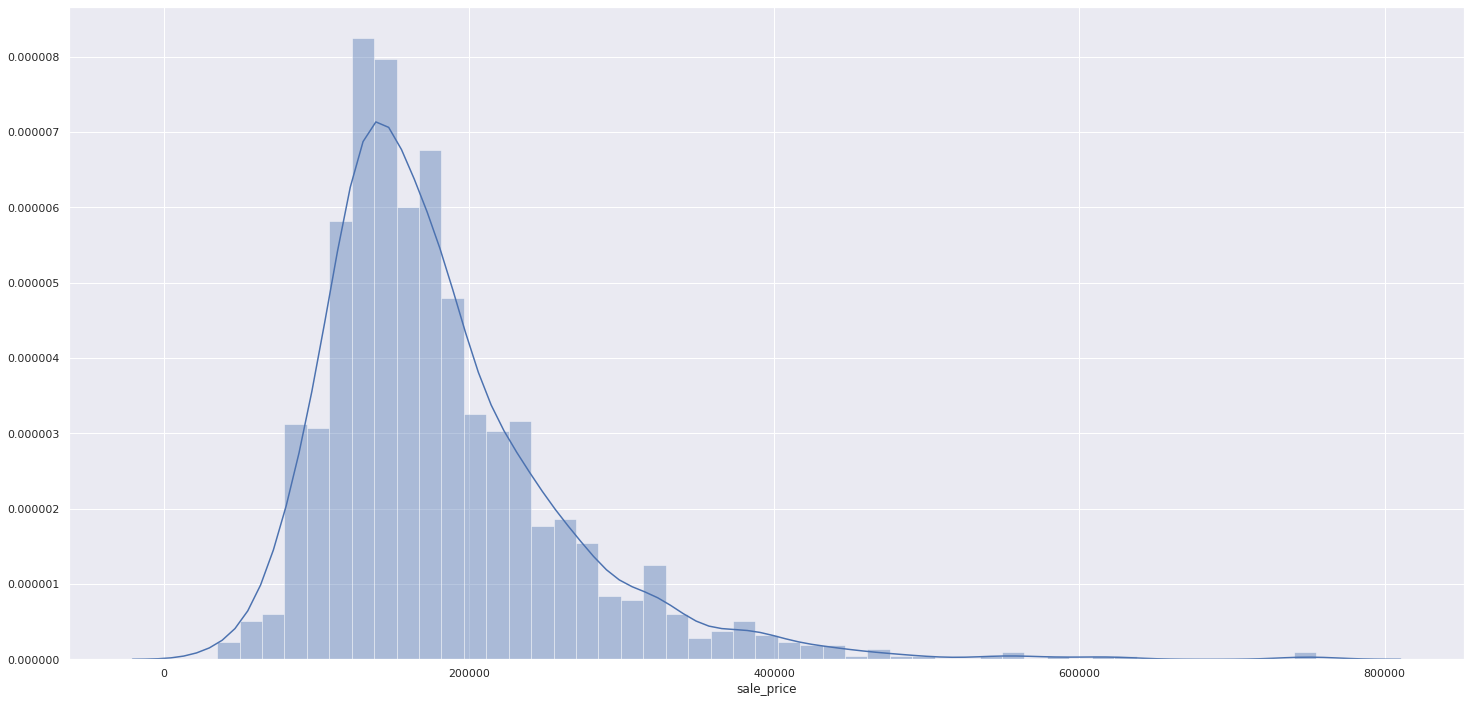

In [23]:
#central tendency - mean, median 
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T
        
#dispersion - std, min, max, range, skew, kurtosis     
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T        
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T        
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T        
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

#concatenate
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

#comparando algumas colunas numéricas 
sns.distplot(df1['sale_price']);

### **1.7.2 Atributos categoricos**

In [24]:
cat_attributes.head()

,ms_zoning,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition1,condition2,bldg_type,house_style,overall_qual,roof_style,roof_matl,exterior1st,exterior2nd,mas_vnr_type,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_type2,heating,heating_qc,central_air,electrical,kitchen_qual,functional,garage_type,garage_finish,garage_qual,garage_cond,paved_drive,sale_type,sale_condition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal


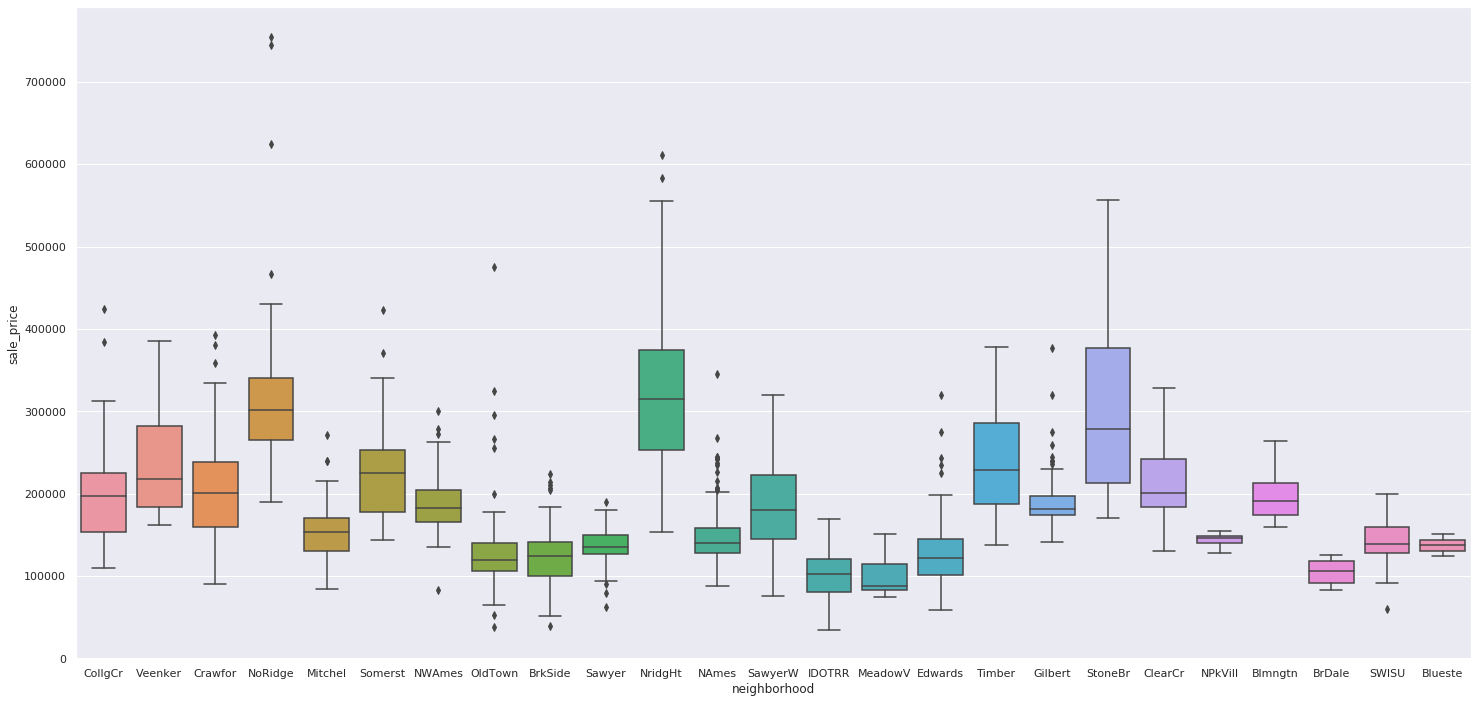

In [25]:
# Analisando os valores categóricos 
#teste = cat_attributes.apply(lambda x: x.unique().shape[0])


#fazendo a plotagem para detecção de outliers 
sns.boxplot(x='neighborhood', y='sale_price', data=df1 );

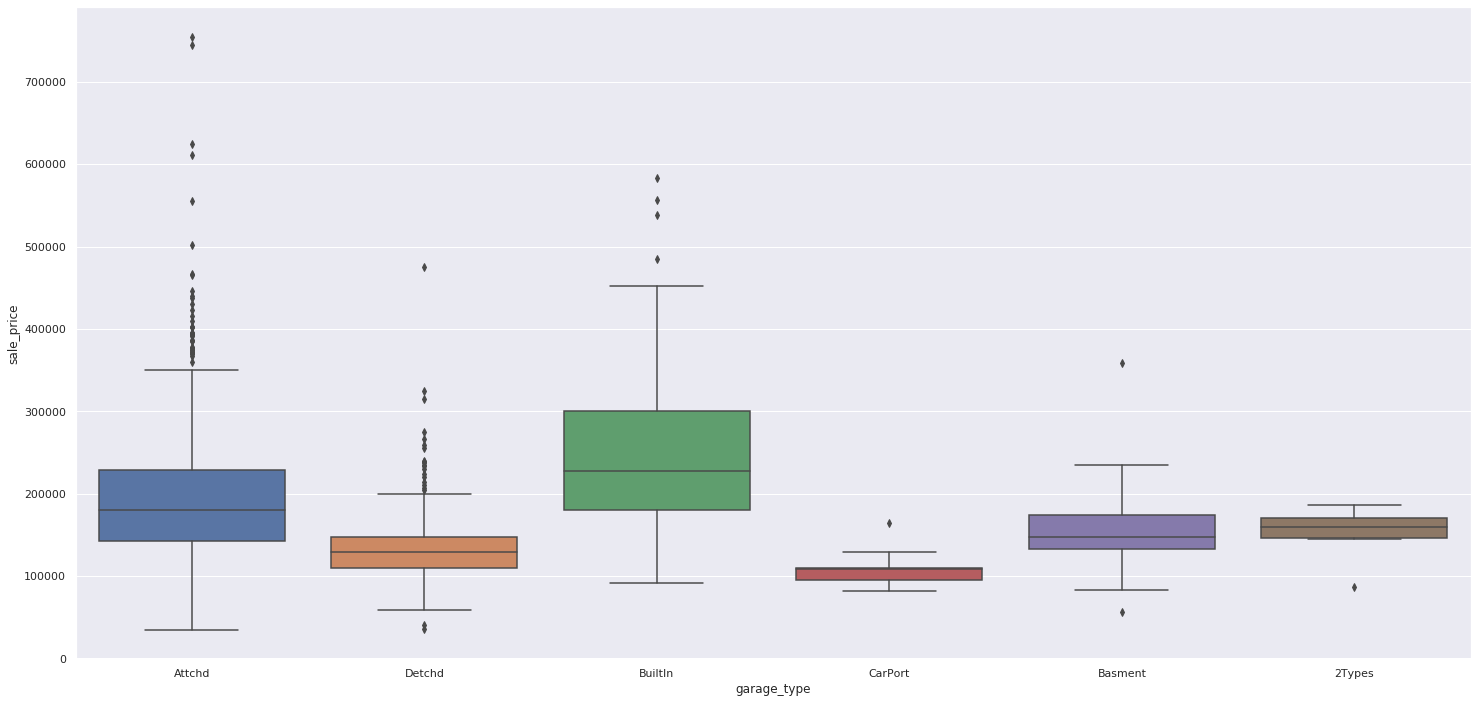

In [26]:
sns.boxplot(x='garage_type', y='sale_price', data=df1 );

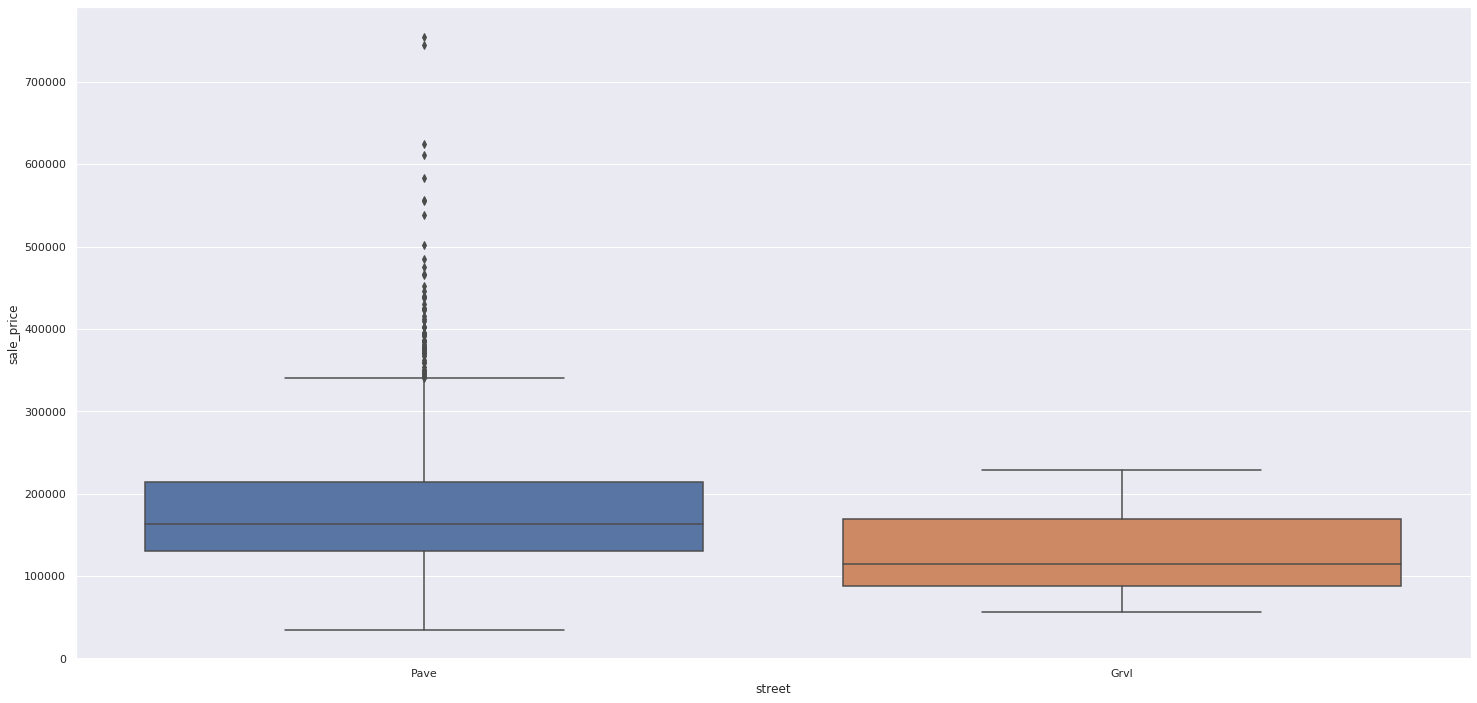

In [27]:
sns.boxplot(x='street', y='sale_price', data=df1 );

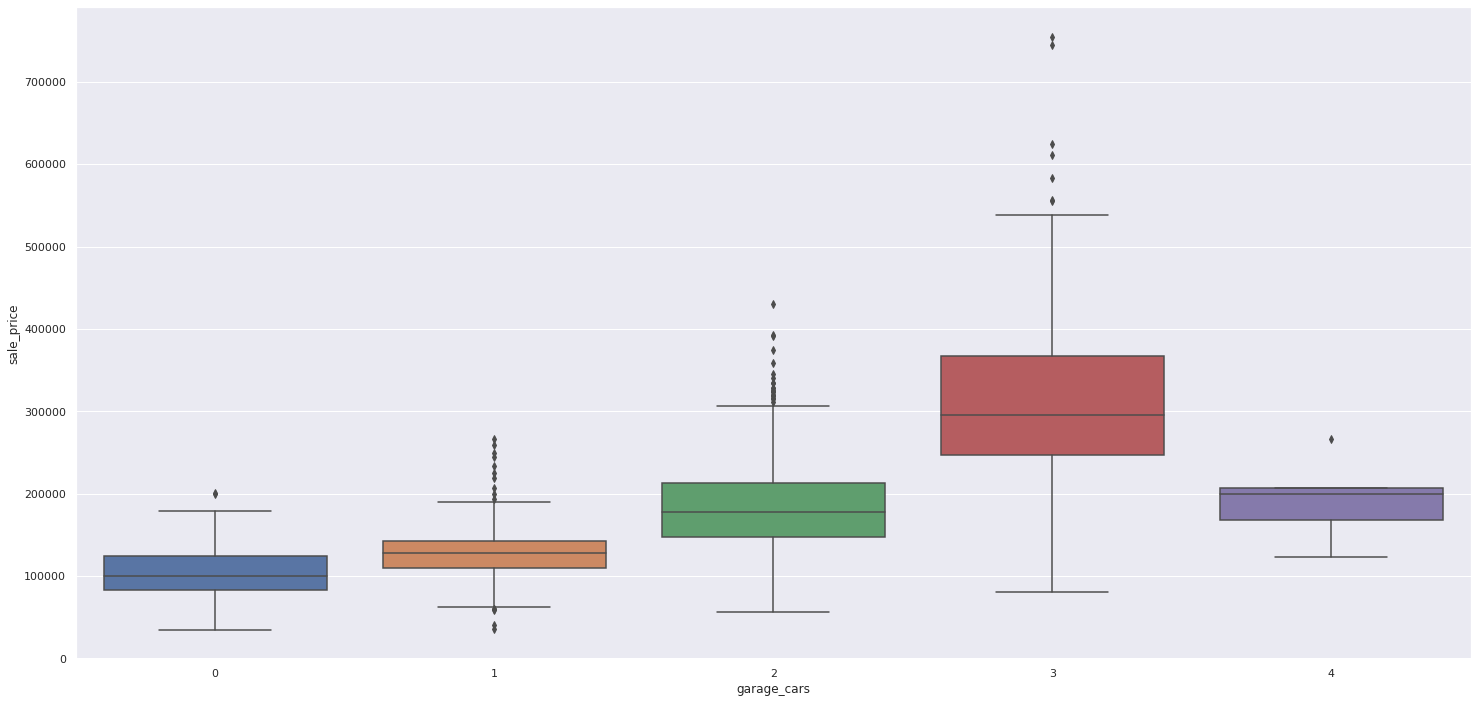

In [28]:
sns.boxplot(x='garage_cars', y='sale_price', data=df1 );

In [29]:
df1.head()

,id,ms_sub_class,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition1,condition2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod_add,roof_style,roof_matl,exterior1st,exterior2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmt_fin_type1,bsmt_fin_sf1,bsmt_fin_type2,bsmt_fin_sf2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abv_gr,kitchen_abv_gr,kitchen_qual,tot_rms_abv_grd,functional,fireplaces,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3_ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,sale_condition,sale_price
0,1,60,RL,65,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


# **2.0. ENGENHARIA DE ATRIBUTOS**

In [30]:
#criando uma cópia do data frame, para ter um backup
df2 = df1.copy()

## **2.1. Mapa Mental de Hipoteses**

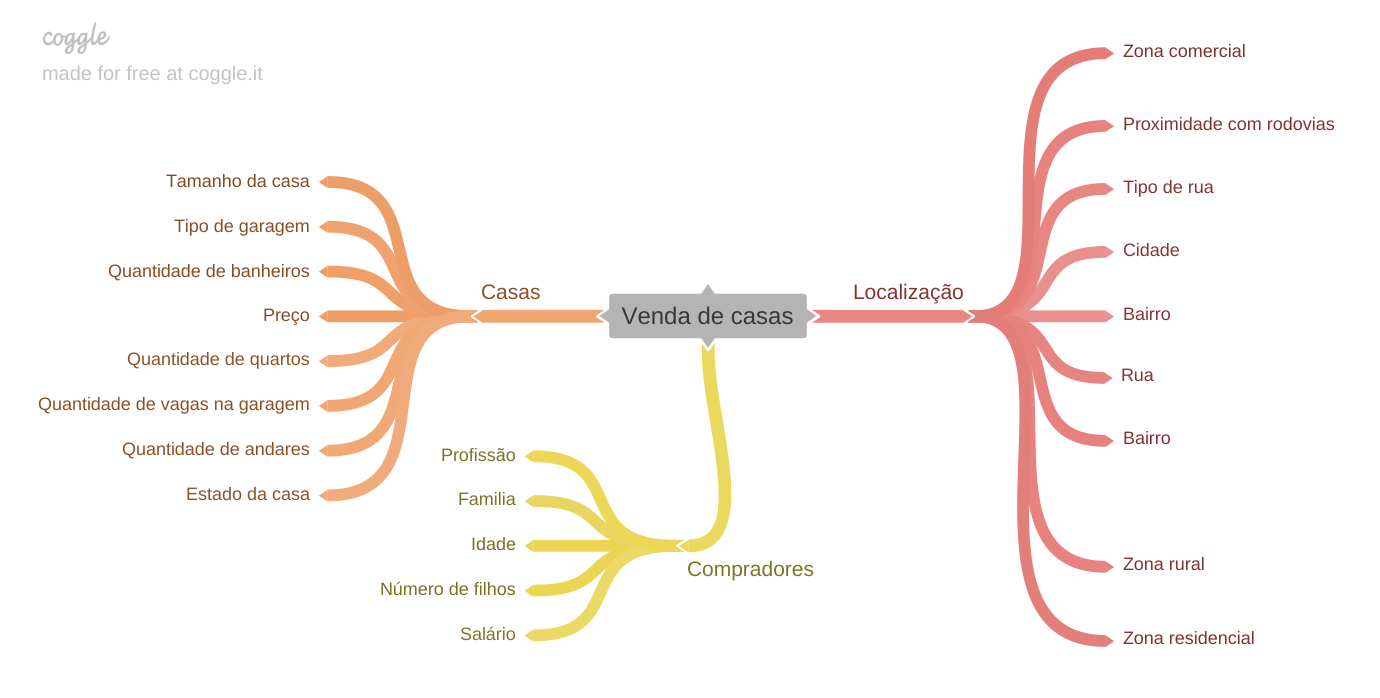

In [31]:
# Montar um mapa mental de hipóteses sobre o produto, usando o coggle.com 
# Mapa mental de hipóteses 

Image('img/Venda_de_casas.png')

## 2.2. Criação de Hipoteses 

In [32]:
# Criando hipóteses sobre os principais tópicos do mapa de hipoteses 

### **2.2.1 Hipoteses Casa**

**1**. Casas com menor valor deveriam vender mais 

**2.** Casas em bom estado deveriam vender mais

**3.** Casas maiores deveriam vender mais 

**4.** Casas com garagens maiores deveriam vender mais

**5.** Casas com mais banheiros deveriam vender mais 

### **2.2.2 Hipoteses Localização**

**1.** Casas em zona residencial deveriam vender mais 

**2.** Casas em zona rural deveriam vender menos

**3.** Casas em ruas pavimentadas deveriam vender mais

**4.** Casas próximas a rodovias deveriam vender mais

**5.** Casas em zonas comerciais deveriam vender menos

## **2.3. Lista final de Hipóteses**

1. Casas com menor valor deveriam vender mais


2. Casas em bom estado deveriam vender mais


3. Casas maiores deveriam vender mais


4. Casas com garagens maiores deveriam vender mais


5. Casas com mais banheiros deveriam vender mais


6. Casas em zona residencial deveriam vender mais


7. Casas em zona rural deveriam vender menos


8. Casas em ruas pavimentadas deveriam vender mais


9. Casas próximas a rodovias deveriam vender mais


10. Casas em zonas comerciais deveriam vender menos

## **2.4. Engenharia de Atributos**

In [33]:
# Fazendo a criação de novas variáveis que sejam úteis para o modelo 

df2['sale_date'] = df2['mo_sold'].astype(str) + df2['yr_sold'].astype(str)
df2['sale_date'] = pd.to_datetime(df2['sale_date'], format='%m%Y')

#  **3.0. FILTAGREM DE VARIAVEIS**

In [34]:
#criando uma cópia do data frame, para ter um backup
df3 = df2.copy()

## **3.1. Filtragem de linha**

In [35]:
# Filtrando as linhas conforma a necessidade do modelo 
# Excluindo linhas duplicadas 
df3 = df3.drop_duplicates()

In [36]:
# Verificando se alguma linha foi excluída(Nenhuma linha excluída)
df3.shape

(1460, 77)

## 3.2. **Seleção das Colunas**

In [37]:
# Selecionando colunas para excluir
df3 = df3.drop(['mo_sold', 'yr_sold'], axis=1)

# **4.0 ANALISE EXPLORATÓRIA DE DADOS**

In [38]:
df4 = df3.copy()

## **4.1. Analise Univariada**

### **4.1.1. Variavel Resposta**

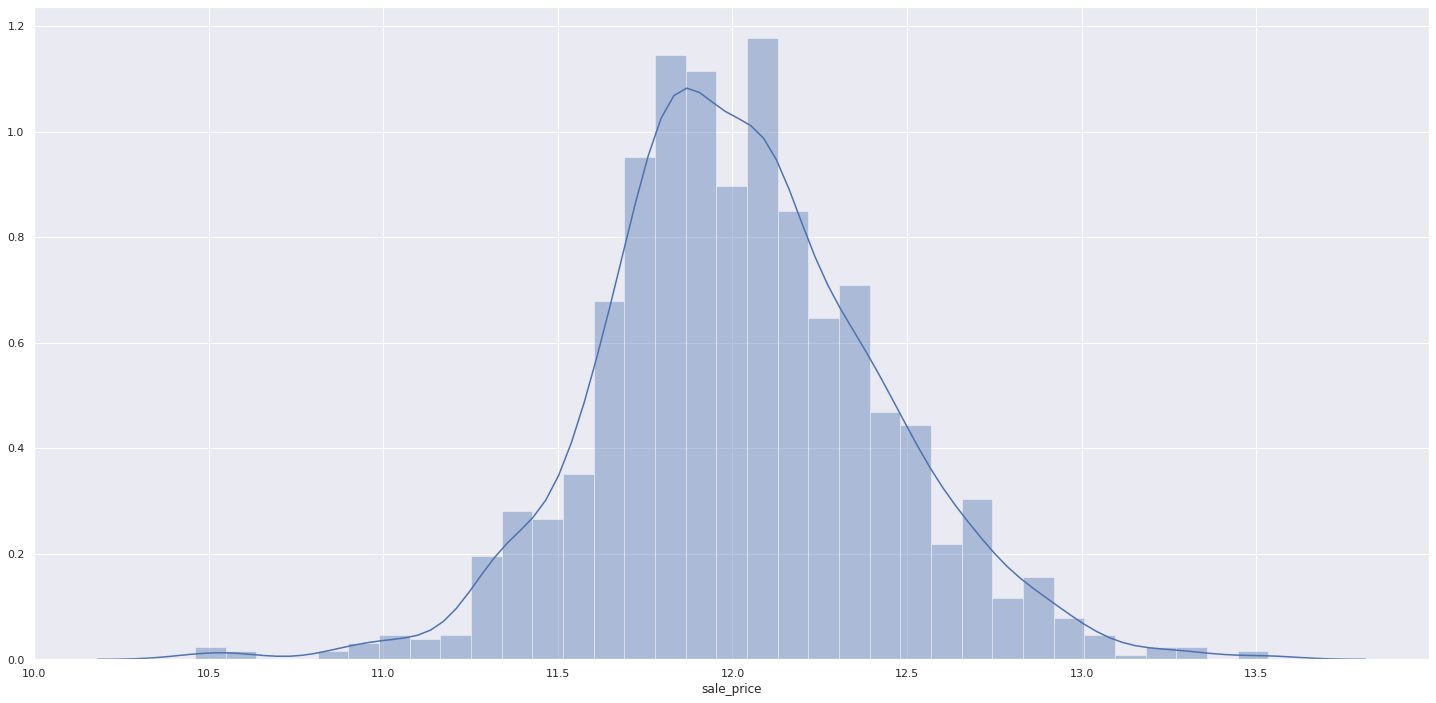

In [39]:
#Plotando a distribuição dos dados da variável reposta para poder analisar melhor 

#para gerar apenas o histograma 
#sns.distplot(df4['sale_price'], kde=False);

#método para aplicar o skew para o lado direito 
sns.distplot(np.log1p((df4['sale_price'])));

### **4.1.2. VARIÁVEIS NUMÉRICAS**

<ipython-input-40-e45e0ac7d1ad>:6: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(bins=25, ax=ax);


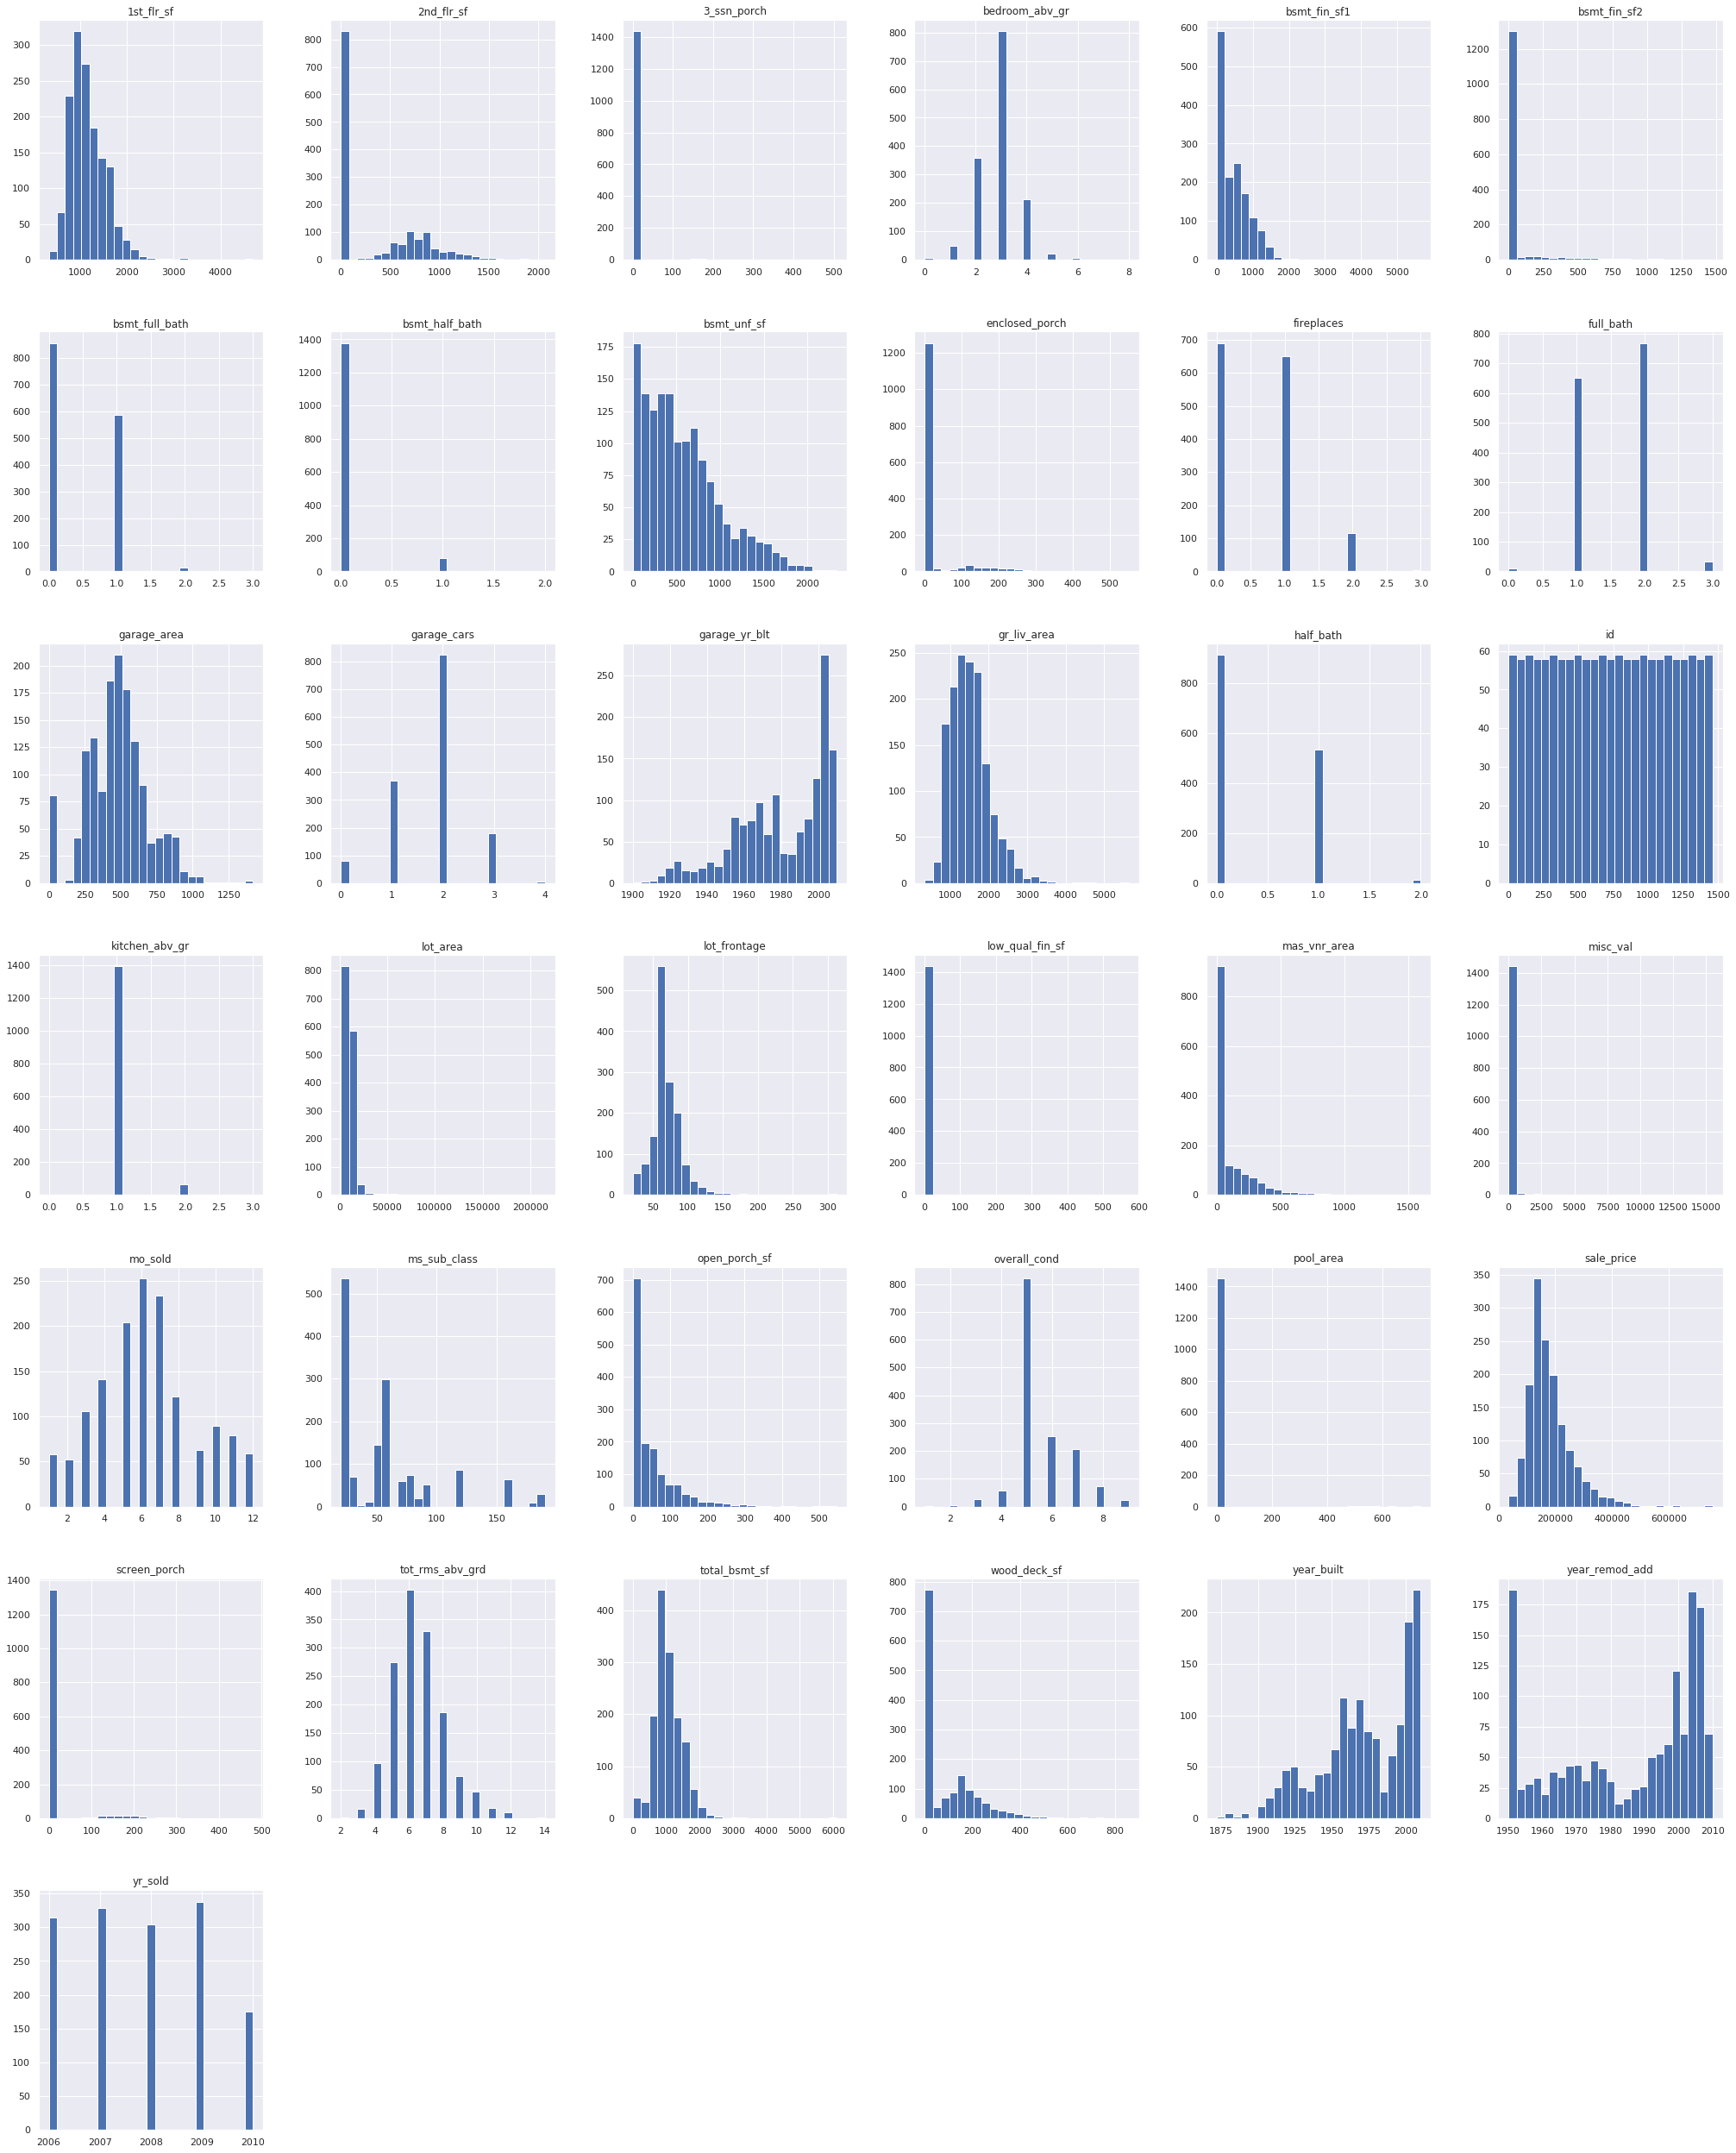

In [40]:
#plotando todos os gráficas com variável do tipo numérica 
fig = plt.figure(figsize = (35,45))
ax = fig.gca()


num_attributes.hist(bins=25, ax=ax);

In [41]:
df4['sale_date'].head()

0   2008-02-01
1   2007-05-01
2   2008-09-01
3   2006-02-01
4   2008-12-01
Name: sale_date, dtype: datetime64[ns]

### **4.1.3. Variaveis Categoricas**

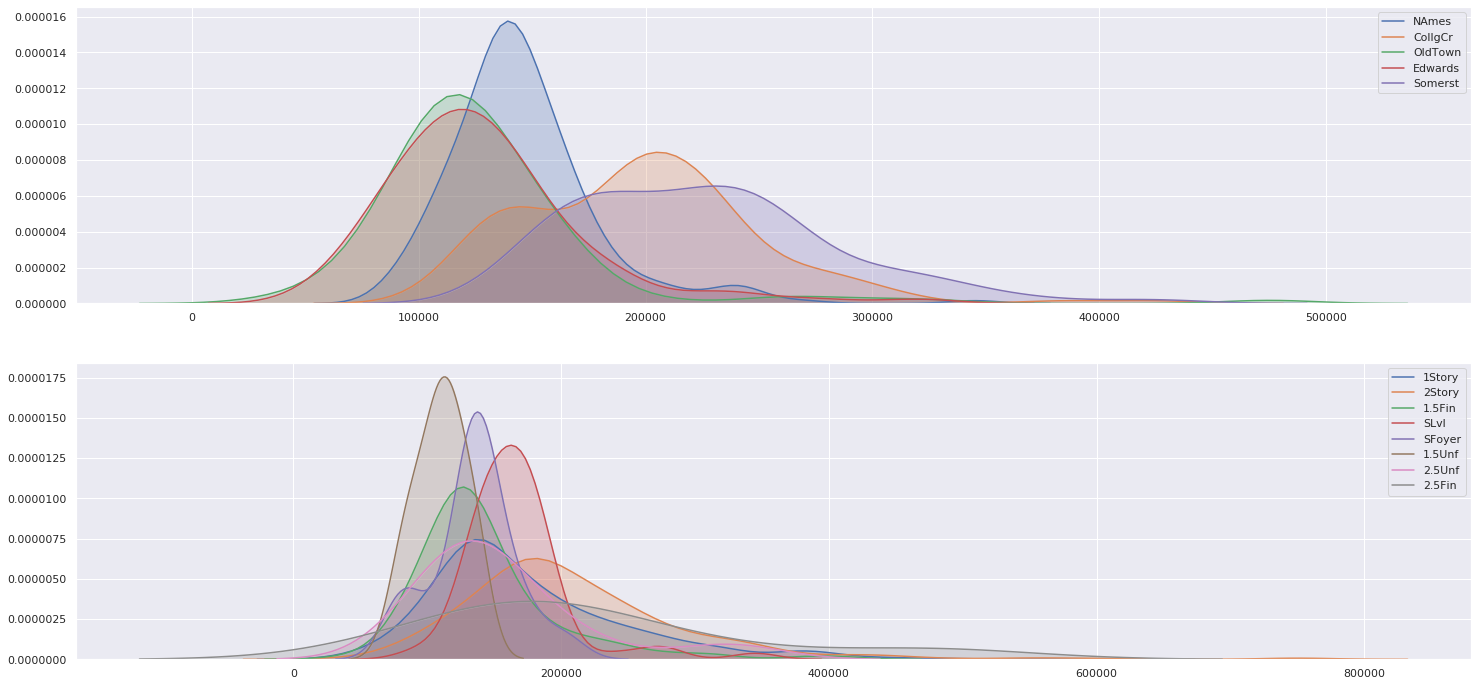

In [42]:
#Analisando os 5 primeiros atributos categóricos

#usando comando para plottar mais de um gráfico 
#3 linhas, 2 colunas, grafico 1
#plt.subplot(3,2,1)
#sns.countplot(df4['neighborhood']);

plt.subplot(2,1,1)
sns.kdeplot(df4[df4['neighborhood']=='NAmes']['sale_price'],label='NAmes', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='CollgCr']['sale_price'],label='CollgCr', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='OldTown']['sale_price'],label='OldTown', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Edwards']['sale_price'],label='Edwards', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Somerst']['sale_price'],label='Somerst', shade='True');
'''sns.kdeplot(df4[df4['neighborhood']=='Gilbert']['sale_price'],label='Gilbert', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='NridgHt']['sale_price'],label='NridgHt', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Sawyer']['sale_price'],label='Sawyer', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='NWAmes']['sale_price'],label='NWAmes', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='SawyerW']['sale_price'],label='SawyerW', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='BrkSide']['sale_price'],label='BrkSide', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Crawfor']['sale_price'],label='Crawfor', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Mitchel']['sale_price'],label='Mitchel', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='NoRidge']['sale_price'],label='NoRidge', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Timber']['sale_price'],label='Timber', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='IDOTRR']['sale_price'],label='IDOTRR', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='ClearCr']['sale_price'],label='ClearCr', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='StoneBr']['sale_price'],label='StoneBr', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='SWISU']['sale_price'],label='SWISU', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='MeadowV']['sale_price'],label='MeadowV', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Blmngtn']['sale_price'],label='Blmngtn', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='BrDale']['sale_price'],label='BrDale', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Veenker']['sale_price'],label='Veenker', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='NPkVill']['sale_price'],label='NPkVill', shade='True');
sns.kdeplot(df4[df4['neighborhood']=='Blueste']['sale_price'],label='Blueste', shade='True');''';


plt.subplot(2,1,2)
sns.kdeplot(df4[df4['house_style']=='1Story']['sale_price'],label='1Story', shade='True');
sns.kdeplot(df4[df4['house_style']=='2Story']['sale_price'],label='2Story', shade='True');
sns.kdeplot(df4[df4['house_style']=='1.5Fin']['sale_price'],label='1.5Fin', shade='True');
sns.kdeplot(df4[df4['house_style']=='SLvl']['sale_price'],label='SLvl', shade='True');
sns.kdeplot(df4[df4['house_style']=='SFoyer']['sale_price'],label='SFoyer', shade='True');
sns.kdeplot(df4[df4['house_style']=='1.5Unf']['sale_price'],label='1.5Unf', shade='True');
sns.kdeplot(df4[df4['house_style']=='2.5Unf']['sale_price'],label='2.5Unf', shade='True');
sns.kdeplot(df4[df4['house_style']=='2.5Fin']['sale_price'],label='2.5Fin', shade='True');
      
   
'''1Story = um andar   
2Story = dois andares   
1.5Fin = um andar e meio   
SLvl   = nível dividido   
SFoyer = vestíbulo dividido   
1.5Unf = 1 e 1/5 andar inacabado   
2.5Unf = 2 e 1/5 andares inacabados   
2.5Fin = 2 e 1/5 andares''';
     
      
      

## **4.2 Analise Bivariada**

In [43]:
# Hora de avaliar todas as hipoteses para checar se são verdadeiras ou não 

### **H1** Casas com menor valor deveriam vender mais
**Verdadeiro:** Casas com menor valor vendem mais. 

In [44]:
plt.subplot(2,1,1)
df4['sale_price'].hist(bins=25);

plt.subplot(2,1,2)
aux2 = df4[['yr_sold', 'sale_price']].groupby(['yr_sold']).sum().reset_index()
#fazendo a plotagem do gráfico com as vendas por assortment pelas semanas do ano 
aux2.pivot(index='yr_sold',columns='yr_sold,' values='sale_price').plot();

SyntaxError: invalid syntax (<ipython-input-44-05a88ede8771>, line 7)

In [ ]:
df4['yr_sold'].head()

### **H2** Casas em bom estado deveriam vender mais 
**Verdadeiro:** Casas em bom estado vendem mais.

In [ ]:
df4['overall_qual'] = df4['overall_qual'].apply(lambda x: 'Very Excellent' if '10' in x else 
                                                'Poor' if '2' in x else 
                                                'Fair' if '3' in x else 
                                                'Below Average' if '4' in x else 
                                                'Average' if '5' in x else 
                                                'Above Average' if '6' in x else 
                                                'Good' if '7' in x else 
                                                'Very Good' if '8' in x else 
                                                'Excellent' if '9' in x else 'Very Pool')

In [ ]:
aux1 = df4[['overall_qual', 'sale_price']].groupby('overall_qual').sum().reset_index()
#plotando o gráfico com as vendas por assortment 
sns.barplot(x='overall_qual', y='sale_price', data=aux1);

### **H3** Casas maiores deveriam vender mais   
**Falso:** Casas maiores não vendem mais. 

In [ ]:
aux1 = df4[df4['lot_area'] <= 60000]
df4['lot_area'].hist(bins=25);

In [ ]:
aux = df4[df4['lot_area'] > 50000]
plt.subplot(2,1,1)
sns.barplot(x='lot_area', y='sale_price', data=aux);

aux1 = df4[df4['lot_area'] <= 50000]
plt.subplot(2,1,2)
sns.barplot(x='lot_area', y='sale_price', data=aux1);

In [ ]:
df4['lot_area'].describe()

### **H4** Casas com garagens maiores deveriam vender mais
**Falso:** Garagens maiores não vendem mais.

In [ ]:
df4['garage_cars'].hist(bins=25);

In [ ]:
df4['garage_area'].hist(bins=25);

### **H5** Casas com mais banheiros deveriam vender mais
**Falso:** Casas com mais banheiros não vendem mais. 

In [ ]:
plt.subplot(2,2,1)
df4['bsmt_full_bath'].hist();

plt.subplot(2,2,2)
df4['bsmt_half_bath'].hist();

plt.subplot(2,2,3)
df4['full_bath'].hist();

plt.subplot(2,2,4)
df4['half_bath'].hist();

### **H6** Casas em zonas residenciais deveriam vender mais
**Verdadeiro:** Casas em zonas residênciais vendem mais. 

In [ ]:
df4['ms_zoning'] = df4['ms_zoning'].apply(lambda x: 
                                                'Commercial' if 'C' in x else 
                                                'Floating Village Residential' if 'FV' in x else 
                                                'Industrial' if 'I' in x else 
                                                'Residential High Density' if 'RH' in x else 
                                                'Residential Low Density' if 'RL' in x else 
                                                'Residential Low Density Park' if 'RP' in x else 
                                                'Residential Medium Density' if 'RM' in x else 'Agriculture')

In [ ]:
df4['ms_zoning'].hist();

### **H7** Casas em zona rural deveriam vender menos
**Verdadeiro:** Casas em zonas rurais vendem menos. 

In [ ]:
df4['ms_zoning'].hist();

### **H8** Casas em ruas pavimentadas deveriam vender mais
**Verdadeiro:** Casas com ruas pavimentadas vendem mais. 

In [ ]:
df4['street'].hist();

### <s>**H9** Casas próximas a rodovias deveriam vender mais</s>

In [ ]:
df4['condition2'].hist(xrot=90);

### **H10** Casas em zonas comerciais deveriam vender menos
**Verdadeiro:** Casas em zonas comerciais vendem menos. 

In [ ]:
df4['ms_zoning'].hist();

### **4.1.2. Resumo das Hipoteses**

In [52]:
tab = [['Hipoteses', 'Conclusao', 'Relevancia'],
       ['H1', 'Falsa', 'Baixa'],
       ['H2', 'Falsa', 'Media'],
       ['H3', 'Falsa', 'Media'],
       ['H4', 'Falsa', 'Baixa'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Baixa'],
       ['H7', 'Falsa', 'Media'],
       ['H8', 'Falsa', 'Alta'],
       ['H9', 'Falsa', 'Alta'],
       ['H10', 'Verdadeira', 'Alta'],
       ['H11', 'Verdadeira', 'Alta'],
       ['H12', 'Verdadeira', 'Baixa']]

print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H6           Falsa        Baixa
H7           Falsa        Media
H8           Falsa        Alta
H9           Falsa        Alta
H10          Verdadeira   Alta
H11          Verdadeira   Alta
H12          Verdadeira   Baixa


## **4.3. Analise Multivariada**

### **4.3.1. Atributos Numericos**

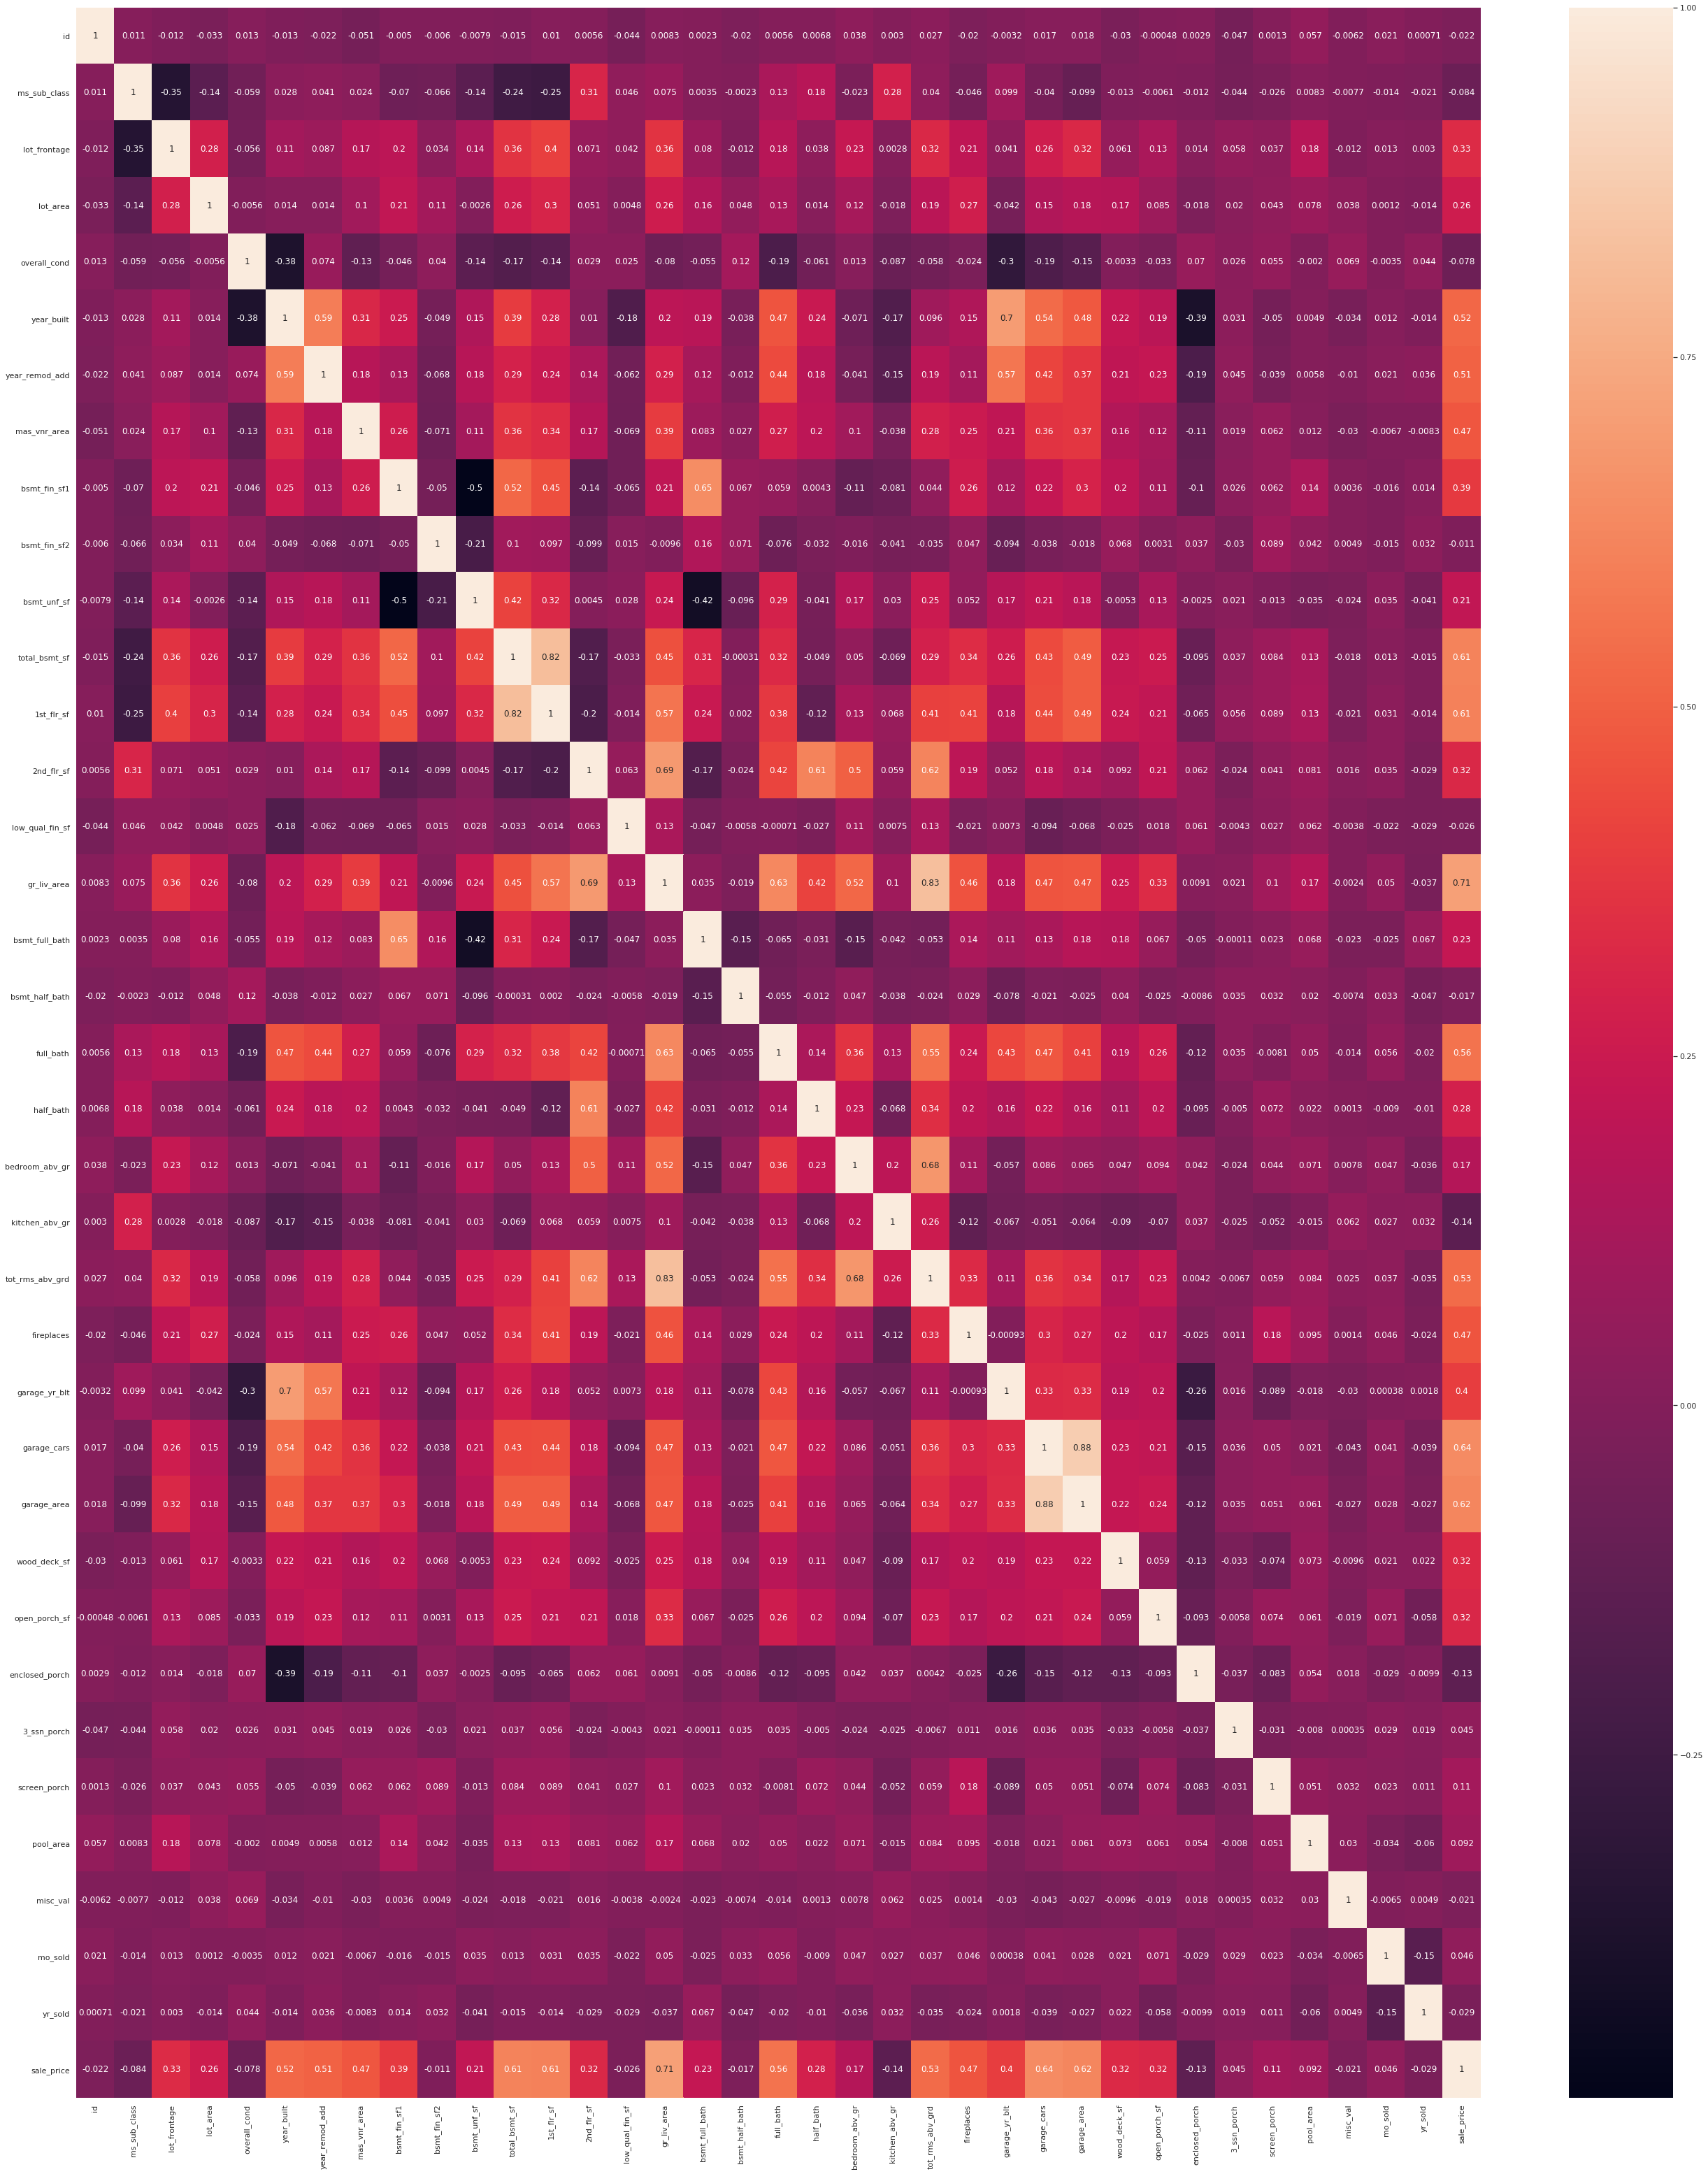

In [49]:
fig = plt.figure(figsize = (45,55))
ax = fig.gca()
# Verificando a correlação entre as variaveis numéricas 
correlacao = num_attributes.corr(method='pearson')
sns.heatmap(correlacao, annot=True, ax=ax);

### **4.3.2. Atributos Categoricos**

In [46]:
a = df4.select_dtypes(include='object')

In [47]:
a1 = cramer_v(a['overall_qual'] ,a['overall_qual'] )
a2 = cramer_v(a['overall_qual'] ,a['ms_zoning'] )
a3 = cramer_v(a['overall_qual'] ,a['street'] )

a4 = cramer_v(a['ms_zoning'] ,a['overall_qual'] )
a5 = cramer_v(a['ms_zoning'] ,a['ms_zoning'] )
a6 = cramer_v(a['ms_zoning'] ,a['street'] )

a7 = cramer_v(a['street'] ,a['overall_qual'] )
a8 = cramer_v(a['street'] ,a['ms_zoning'] )
a9 = cramer_v(a['street'] ,a['street'] )

df = pd.DataFrame({'overall_qual':[a1, a2, a3],
                   'ms_zoning':[a4, a5, a6],
                   'street':[a7, a8, a9]})
df = df.set_index(df.columns)

In [48]:
df

,overall_qual,ms_zoning,street
overall_qual,1.003097,0.205860,0.106944
ms_zoning,0.205860,1.001373,0.254822
street,0.106944,0.254822,0.916637


# **5.0 PREPARAÇÃO DOS DADOS**

In [57]:
df5 = df4.copy()

## **5.1 Normalização**

In [ ]:
#nenhum dado precisou ser normalizado nesse DF 

## **5.2 Reescalação**

In [58]:
#Separando as variáveis númericas das demais variáveis 
a = df5.select_dtypes(include=['int64', 'float64'])

In [60]:
# Verificando as variáveis não cíclicas uma a uma 

a['mas_vnr_area'] = a['mas_vnr_area'].astype(int);
a['yr_sold'] = df1['yr_sold'];

<ipython-input-60-e03f7aedb92d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['mas_vnr_area'] = a['mas_vnr_area'].astype(int);
<ipython-input-60-e03f7aedb92d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['yr_sold'] = df1['yr_sold'];


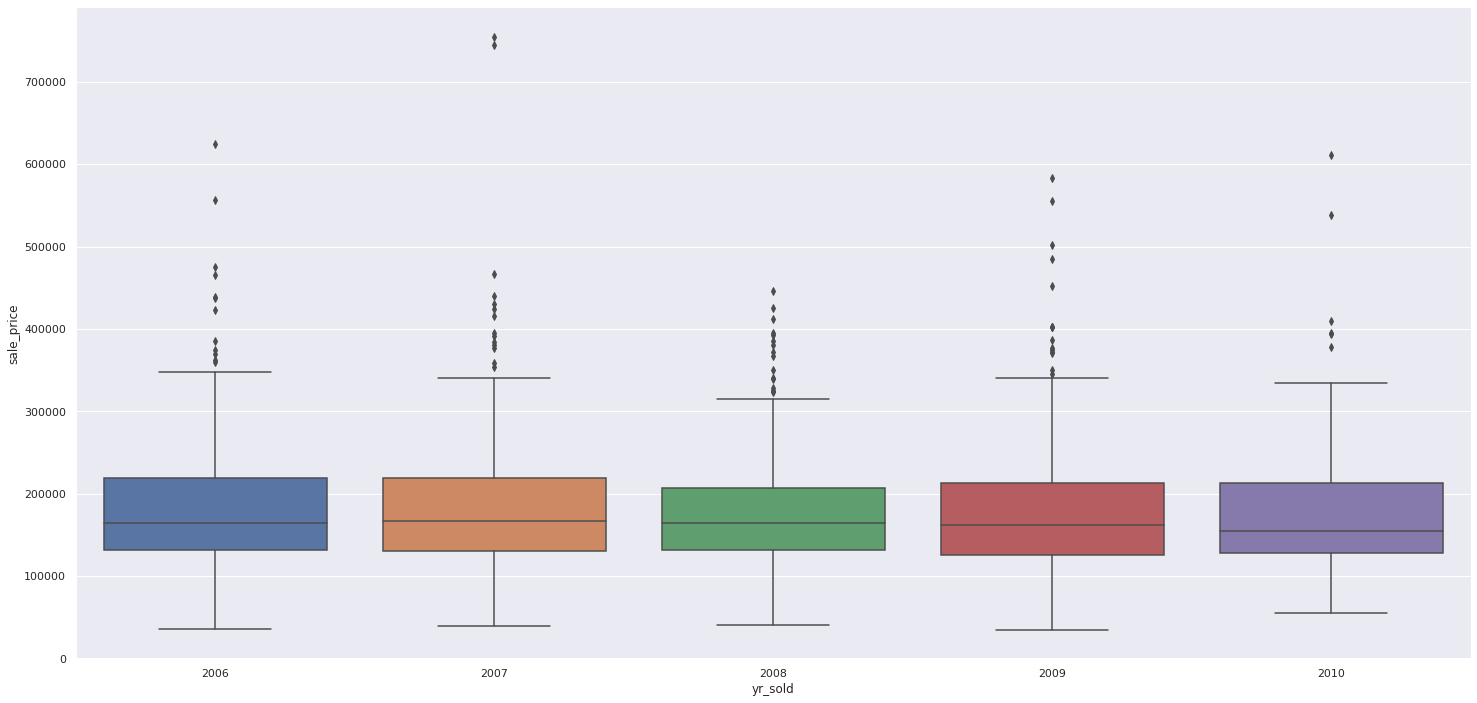

In [61]:
sns.boxplot(x='yr_sold', y='sale_price', data=a);

In [294]:
#precisamos verificar qual variável numérica tem outlier para decidir qual scaling será aplicado 

#RobustScaler é aplicado quando há outlier na variável 

#MinMaxScaler é aplicado quando não há outlier na variável 


robust = RobustScaler()

df5['year_built'] = robust.fit_transform(df5[['year_built']].values)
pickle.dump(robust, open('parameter/year_built_scaler.pkl', 'wb'))

df5['ms_sub_class'] = robust.fit_transform(df5[['ms_sub_class']].values)
pickle.dump(robust, open('parameter/ms_sub_class_scaler.pkl', 'wb'))

df5['ms_sub_class'] = robust.fit_transform(df5[['ms_sub_class']].values)
pickle.dump(robust, open('parameter/ms_sub_class_scaler.pkl', 'wb'))

df5['lot_frontage'] = robust.fit_transform(df5[['lot_frontage']].values)
pickle.dump(robust, open('parameter/lot_frontage_scaler.pkl', 'wb'))

df5['lot_area'] = robust.fit_transform(df5[['lot_area']].values)
pickle.dump(robust, open('parameter/lot_area_scaler.pkl', 'wb'))

df5['overall_cond'] = robust.fit_transform(df5[['overall_cond']].values)
pickle.dump(robust, open('parameter/overall_cond_scaler.pkl', 'wb'))

df5['year_remod_add'] = robust.fit_transform(df5[['year_remod_add']].values)
pickle.dump(robust, open('parameter/year_remod_add_scaler.pkl', 'wb'))

df5['mas_vnr_area'] = robust.fit_transform(df5[['mas_vnr_area']].values)
pickle.dump(robust, open('parameter/mas_vnr_area_scaler.pkl', 'wb'))

df5['bsmt_fin_sf1'] = robust.fit_transform(df5[['bsmt_fin_sf1']].values)
pickle.dump(robust, open('parameter/bsmt_fin_sf1_scaler.pkl', 'wb'))

df5['bsmt_fin_sf2'] = robust.fit_transform(df5[['bsmt_fin_sf2']].values)
pickle.dump(robust, open('parameter/bsmt_fin_sf2_scaler.pkl', 'wb'))

df5['bsmt_unf_sf'] = robust.fit_transform(df5[['bsmt_unf_sf']].values)
pickle.dump(robust, open('parameter/bsmt_unf_sf_scaler.pkl', 'wb'))

df5['total_bsmt_sf'] = robust.fit_transform(df5[['total_bsmt_sf']].values)
pickle.dump(robust, open('parameter/total_bsmt_sf_scaler.pkl', 'wb'))

df5['1st_flr_sf'] = robust.fit_transform(df5[['1st_flr_sf']].values)
pickle.dump(robust, open('parameter/1st_flr_sf_scaler.pkl', 'wb'))

df5['2nd_flr_sf'] = robust.fit_transform(df5[['2nd_flr_sf']].values)
pickle.dump(robust, open('parameter/2nd_flr_sf_scaler.pkl', 'wb'))

df5['low_qual_fin_sf'] = robust.fit_transform(df5[['low_qual_fin_sf']].values)
pickle.dump(robust, open('parameter/low_qual_fin_sf_scaler.pkl', 'wb'))

df5['1st_flr_sf'] = robust.fit_transform(df5[['1st_flr_sf']].values)
pickle.dump(robust, open('parameter/1st_flr_sf_scaler.pkl', 'wb'))

df5['gr_liv_area'] = robust.fit_transform(df5[['gr_liv_area']].values)
pickle.dump(robust, open('parameter/gr_liv_area_scaler.pkl', 'wb'))

df5['bsmt_full_bath'] = robust.fit_transform(df5[['bsmt_full_bath']].values)
pickle.dump(robust, open('parameter/bsmt_full_bath_scaler.pkl', 'wb'))

df5['bsmt_half_bath'] = robust.fit_transform(df5[['bsmt_half_bath']].values)
pickle.dump(robust, open('parameter/bsmt_half_bath_scaler.pkl', 'wb'))

df5['full_bath'] = robust.fit_transform(df5[['full_bath']].values)
pickle.dump(robust, open('parameter/full_bath_scaler.pkl', 'wb'))

df5['half_bath'] = robust.fit_transform(df5[['half_bath']].values)
pickle.dump(robust, open('parameter/half_bath_scaler.pkl', 'wb'))

df5['bsmt_full_bath'] = robust.fit_transform(df5[['bsmt_full_bath']].values)
pickle.dump(robust, open('parameter/bsmt_full_bath_scaler.pkl', 'wb'))

df5['bedroom_abv_gr'] = robust.fit_transform(df5[['bedroom_abv_gr']].values)
pickle.dump(robust, open('parameter/bedroom_abv_gr_scaler.pkl', 'wb'))

df5['kitchen_abv_gr'] = robust.fit_transform(df5[['kitchen_abv_gr']].values)
pickle.dump(robust, open('parameter/kitchen_abv_gr_scaler.pkl', 'wb'))

df5['tot_rms_abv_grd'] = robust.fit_transform(df5[['tot_rms_abv_grd']].values)
pickle.dump(robust, open('parameter/tot_rms_abv_grd_scaler.pkl', 'wb'))

df5['fireplaces'] = robust.fit_transform(df5[['fireplaces']].values)
pickle.dump(robust, open('parameter/fireplaces_scaler.pkl', 'wb'))

df5['garage_yr_blt'] = robust.fit_transform(df5[['garage_yr_blt']].values)
pickle.dump(robust, open('parameter/garage_yr_blt_scaler.pkl', 'wb'))

df5['garage_cars'] = robust.fit_transform(df5[['garage_cars']].values)
pickle.dump(robust, open('parameter/garage_cars_scaler.pkl', 'wb'))

df5['garage_area'] = robust.fit_transform(df5[['garage_area']].values)
pickle.dump(robust, open('parameter/garage_area_scaler.pkl', 'wb'))

df5['wood_deck_sf'] = robust.fit_transform(df5[['wood_deck_sf']].values)
pickle.dump(robust, open('parameter/wood_deck_sf_scaler.pkl', 'wb'))

df5['open_porch_sf'] = robust.fit_transform(df5[['open_porch_sf']].values)
pickle.dump(robust, open('parameter/open_porch_sf_scaler.pkl', 'wb'))

df5['enclosed_porch'] = robust.fit_transform(df5[['enclosed_porch']].values)
pickle.dump(robust, open('parameter/enclosed_porch_scaler.pkl', 'wb'))

df5['3_ssn_porch'] = robust.fit_transform(df5[['3_ssn_porch']].values)
pickle.dump(robust, open('parameter/3_ssn_porch_scaler.pkl', 'wb'))

df5['screen_porch'] = robust.fit_transform(df5[['screen_porch']].values)
pickle.dump(robust, open('parameter/screen_porch_scaler.pkl', 'wb'))

df5['pool_area'] = robust.fit_transform(df5[['pool_area']].values)
pickle.dump(robust, open('parameter/pool_area_scaler.pkl', 'wb'))

df5['misc_val'] = robust.fit_transform(df5[['misc_val']].values)
pickle.dump(robust, open('parameter/misc_val_scaler.pkl', 'wb'))


mms = MinMaxScaler()
# neste DF não existem variáveis numéricas sem outliers



## **5.3 Transformação**

### **5.3.1 Encoding**

In [118]:
a = df5.select_dtypes(include=['object'])

In [285]:
# Aplicando as transformações nas variaveis categoricas 

# One Hot Encoder(Dumming Encoding)

#Label Encoder
LE = LabelEncoder()

df5['ms_zoning'] = LE.fit_transform(df5['ms_zoning'])
pickle.dump(LE, open('parameter/ms_zoning_scaler.pkl', 'wb'))

df5['street'] = LE.fit_transform(df5['street'])
pickle.dump(LE, open('parameter/street_scaler.pkl', 'wb'))

df5['lot_shape'] = LE.fit_transform(df5['lot_shape'])
pickle.dump(LE, open('parameter/lot_shape_scaler.pkl', 'wb'))

df5['land_contour'] = LE.fit_transform(df5['land_contour'])
pickle.dump(LE, open('parameter/land_contour_scaler.pkl', 'wb'))

df5['utilities'] = LE.fit_transform(df5['utilities'])
pickle.dump(LE, open('parameter/utilities_scaler.pkl', 'wb'))

df5['lot_config'] = LE.fit_transform(df5['lot_config'])
pickle.dump(LE, open('parameter/lot_config_scaler.pkl', 'wb'))

df5['land_slope'] = LE.fit_transform(df5['land_slope'])
pickle.dump(LE, open('parameter/land_slope_scaler.pkl', 'wb'))

df5['neighborhood'] = LE.fit_transform(df5['neighborhood'])
pickle.dump(LE, open('parameter/neighborhood_scaler.pkl', 'wb'))

df5['condition1'] = LE.fit_transform(df5['condition1'])
pickle.dump(LE, open('parameter/condition1_scaler.pkl', 'wb'))

df5['condition2'] = LE.fit_transform(df5['condition2'])
pickle.dump(LE, open('parameter/condition2_scaler.pkl', 'wb'))

df5['bldg_type'] = LE.fit_transform(df5['bldg_type'])
pickle.dump(LE, open('parameter/bldg_type_scaler.pkl', 'wb'))

df5['house_style'] = LE.fit_transform(df5['house_style'])
pickle.dump(LE, open('parameter/house_style_scaler.pkl', 'wb'))

df5['overall_qual'] = LE.fit_transform(df5['overall_qual'])
pickle.dump(LE, open('parameter/overall_qual_scaler.pkl', 'wb'))

df5['roof_style'] = LE.fit_transform(df5['roof_style'])
pickle.dump(LE, open('parameter/roof_style_scaler.pkl', 'wb'))

df5['roof_matl'] = LE.fit_transform(df5['roof_matl'])
pickle.dump(LE, open('parameter/roof_matl_scaler.pkl', 'wb'))

df5['exterior1st'] = LE.fit_transform(df5['exterior1st'])
pickle.dump(LE, open('parameter/exterior1st_scaler.pkl', 'wb'))

df5['exterior2nd'] = LE.fit_transform(df5['exterior2nd'])
pickle.dump(LE, open('parameter/exterior2nd_scaler.pkl', 'wb'))

df5['mas_vnr_type'] = LE.fit_transform(df5['mas_vnr_type'])
pickle.dump(LE, open('parameter/mas_vnr_type_scaler.pkl', 'wb'))

df5['exter_qual'] = LE.fit_transform(df5['exter_qual'])
pickle.dump(LE, open('parameter/exter_qual_scaler.pkl', 'wb'))

df5['exter_cond'] = LE.fit_transform(df5['exter_cond'])
pickle.dump(LE, open('parameter/exter_cond_scaler.pkl', 'wb'))

df5['foundation'] = LE.fit_transform(df5['foundation'])
pickle.dump(LE, open('parameter/foundation_scaler.pkl', 'wb'))

df5['bsmt_qual'] = LE.fit_transform(df5['bsmt_qual'])
pickle.dump(LE, open('parameter/bsmt_qual_scaler.pkl', 'wb'))

df5['bsmt_cond'] = LE.fit_transform(df5['bsmt_cond'])
pickle.dump(LE, open('parameter/bsmt_cond_scaler.pkl', 'wb'))

df5['bsmt_exposure'] = LE.fit_transform(df5['bsmt_exposure'])
pickle.dump(LE, open('parameter/bsmt_exposure_scaler.pkl', 'wb'))

df5['bsmt_fin_type1'] = LE.fit_transform(df5['bsmt_fin_type1'])
pickle.dump(LE, open('parameter/bsmt_fin_type1_scaler.pkl', 'wb'))

df5['bsmt_fin_type2'] = LE.fit_transform(df5['bsmt_fin_type2'])
pickle.dump(LE, open('parameter/bsmt_fin_type2_scaler.pkl', 'wb'))

df5['heating'] = LE.fit_transform(df5['heating'])
pickle.dump(LE, open('parameter/heating_scaler.pkl', 'wb'))

df5['heating_qc'] = LE.fit_transform(df5['heating_qc'])
pickle.dump(LE, open('parameter/heating_qc_scaler.pkl', 'wb'))

df5['central_air'] = LE.fit_transform(df5['central_air'])
pickle.dump(LE, open('parameter/central_air_scaler.pkl', 'wb'))

df5['electrical'] = LE.fit_transform(df5['electrical'])
pickle.dump(LE, open('parameter/electrical_scaler.pkl', 'wb'))

df5['kitchen_qual'] = LE.fit_transform(df5['kitchen_qual'])
pickle.dump(LE, open('parameter/kitchen_qual_scaler.pkl', 'wb'))

df5['functional'] = LE.fit_transform(df5['functional'])
pickle.dump(LE, open('parameter/functional_scaler.pkl', 'wb'))

df5['garage_type'] = LE.fit_transform(df5['garage_type'])
pickle.dump(LE, open('parameter/garage_type_scaler.pkl', 'wb'))

df5['garage_finish'] = LE.fit_transform(df5['garage_finish'])
pickle.dump(LE, open('parameter/garage_finish_scaler.pkl', 'wb'))

df5['garage_qual'] = LE.fit_transform(df5['garage_qual'])
pickle.dump(LE, open('parameter/garage_qual_scaler.pkl', 'wb'))

df5['garage_cond'] = LE.fit_transform(df5['garage_cond'])
pickle.dump(LE, open('parameter/garage_cond_scaler.pkl', 'wb'))

df5['paved_drive'] = LE.fit_transform(df5['paved_drive'])
pickle.dump(LE, open('parameter/paved_drive_scaler.pkl', 'wb'))

df5['sale_type'] = LE.fit_transform(df5['sale_type'])
pickle.dump(LE, open('parameter/sale_type_scaler.pkl', 'wb'))

df5['sale_condition'] = LE.fit_transform(df5['sale_condition'])
pickle.dump(LE, open('parameter/sale_condition_scaler.pkl', 'wb'))


# Ordinal Encoding

### **5.3.2 Transformação da variável resposta**

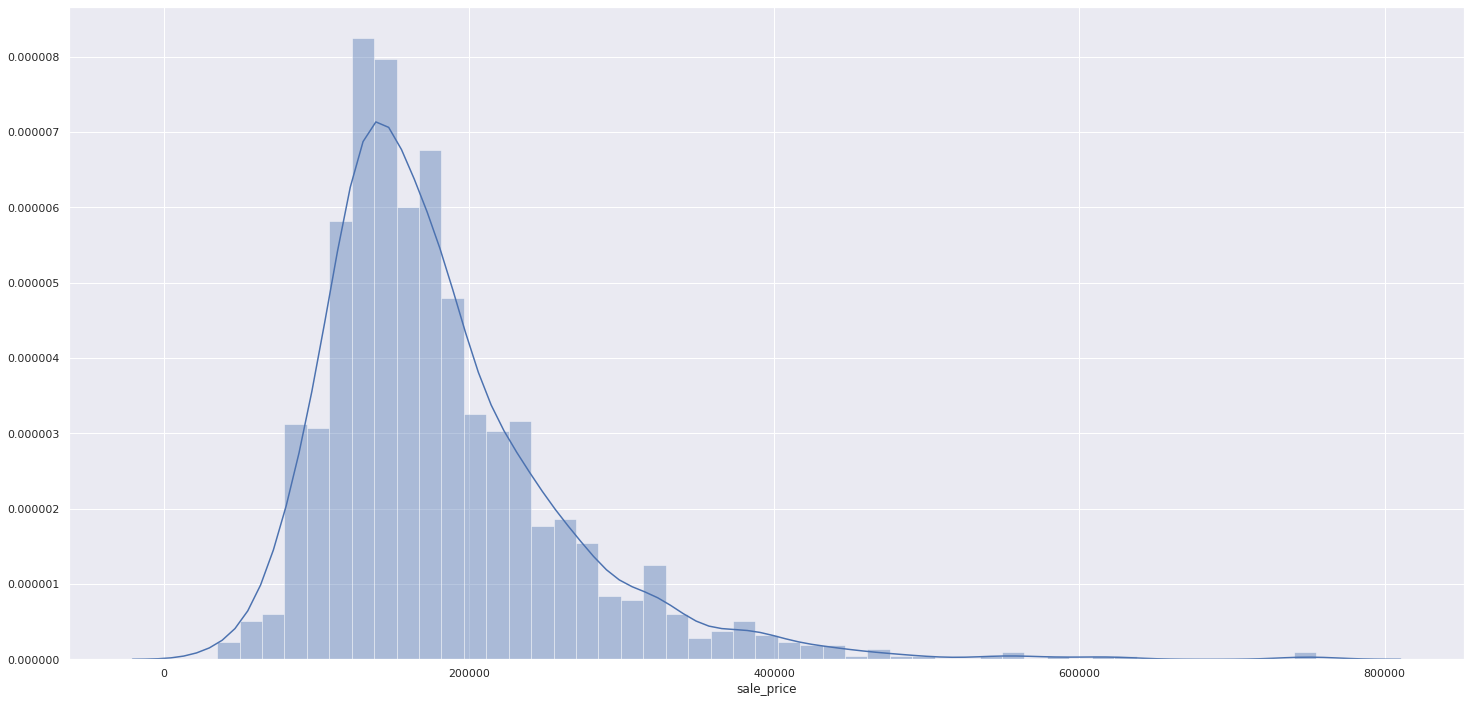

In [63]:
#plotando a distribuição dos dados da variável resposta 
sns.distplot(df5['sale_price']);

In [64]:
#reescalando a variável resposta 
df5['sale_price'] = np.log1p(df5['sale_price'])

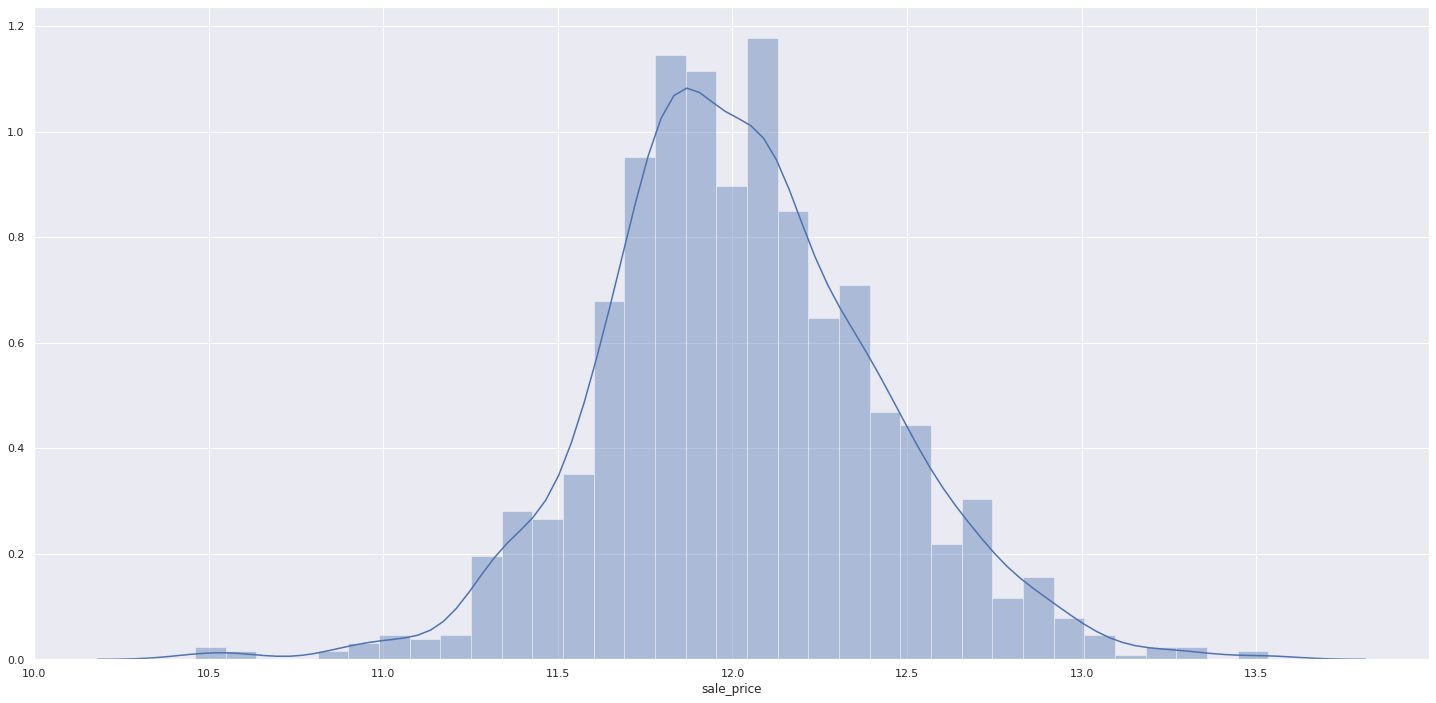

In [65]:
sns.distplot(df5['sale_price']);

### **5.3.3. Transformacao de Natureza**

In [120]:
#VARIÁVEIS CÍCLICAS 
#aplicando o seno e cosseno nas variáveis cíclicas, para fazer a transformação dos dados de categóricos(letras) para inteiros 

df5['sale_date_sin'] = df1['mo_sold'].apply(lambda x: np.sin(x *(2. * np.pi /30)))
df5['sale_date_cos'] = df1['mo_sold'].apply(lambda x: np.cos(x *(2. * np.pi /30)))

# **6.0 SELEÇÃO DE ATRIBUTOS**

In [121]:
df6 = df5.copy()

## **6.1 Dividir base de dados em treino e teste**

In [122]:
#criando base de dados de treino 
X_train = df6[df6['sale_date'].dt.year < 2008]
Y_train = X_train['sale_price']

#criando base de dados de teste 
X_test = df6[df6['sale_date'].dt.year >= 2008]
Y_test = X_test['sale_price']

print('Training min date in train base: {}'.format(X_train['sale_date'].dt.year.min()))
print('Training max date in train base: {}'.format(X_train['sale_date'].dt.year.max()))

print('\nTraining min date in test base: {}'.format(X_test['sale_date'].dt.year.min()))
print('Training max date in test base: {}'.format(X_test['sale_date'].dt.year.max()))

Training min date in train base: 2006
Training max date in train base: 2007

Training min date in test base: 2008
Training max date in test base: 2010


## **6.2 Boruta como seletor de atributos**
**RESULTADOS DO BORUTA JÁ SALVOS EM VARIÁVEL**

In [98]:
df6.dtypes

id                          int64
ms_sub_class                int64
ms_zoning                  object
lot_frontage                int64
lot_area                    int64
street                     object
lot_shape                  object
land_contour               object
utilities                  object
lot_config                 object
land_slope                 object
neighborhood               object
condition1                 object
condition2                 object
bldg_type                  object
house_style                object
overall_qual               object
overall_cond                int64
year_built                  int64
year_remod_add              int64
roof_style                 object
roof_matl                  object
exterior1st                object
exterior2nd                object
mas_vnr_type               object
mas_vnr_area                int64
exter_qual                 object
exter_cond                 object
foundation                 object
bsmt_qual     

In [103]:
type(x_train_n)

numpy.ndarray

In [135]:
# ajustando as variáveis de treino e teste para que possam ser aplicadas no boruta 

x_train_n = X_train.drop(['sale_date', 'sale_price'], axis=1).values
y_train_n = Y_train.values.ravel()

#defirindo parametros do algoritmo random forest 
rf = RandomForestRegressor(n_jobs = -1)

#definindo parametros do boruta 
boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=0).fit(x_train_n, y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	9 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	10 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	11 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	12 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	13 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	14 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	15 / 100
Confirmed: 	17
Tentative: 	9
Rejected: 	49
Iteration: 	16 / 100
Confirmed: 	19
Tentative: 	7
Reject

### **6.2.1 Melhores atributos segundo Boruta**

In [140]:
#criando uma lista com as colunas que foram selecionadas pelo boruta 
cols_selected = boruta.support_.tolist()

#criando variável para localizar as colunas que foram selecionadas 
# VERIFICAR SE ESSAS COLUNAS AINDA ESTÃO NO DF E TIRA-LAS CASO ESTEJAM 'customers', 'open'
x_train_fs = X_train.drop(['sale_date','sale_price'], axis=1)
cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

#verificando colunas não selecionadas 
cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))

## **6.3 Seleção manual de atributos**
**RESULTADOS DO BORUTA SALVOS AQUI**

In [105]:
cols_selected_boruta = ['ms_zoning','lot_area','neighborhood','overall_qual','overall_cond','year_built','year_remod_add','exter_qual','bsmt_qual','bsmt_fin_sf1',
                        'bsmt_unf_sf','total_bsmt_sf','1st_flr_sf','2nd_flr_sf','gr_liv_area','full_bath','garage_finish','garage_cars','garage_area']

cols_not_selected_boruta = ['3_ssn_porch','bedroom_abv_gr','bldg_type','bsmt_cond','bsmt_exposure','bsmt_fin_sf2','bsmt_fin_type1','bsmt_fin_type2','bsmt_full_bath',
 'bsmt_half_bath','central_air','condition1','condition2','electrical','enclosed_porch','exter_cond','exterior1st','exterior2nd','fireplaces','foundation','functional',
 'garage_cond','garage_qual','garage_type','garage_yr_blt','half_bath','heating','heating_qc','house_style','id','kitchen_abv_gr','kitchen_qual','land_contour',
 'land_slope','lot_config','lot_frontage','lot_shape','low_qual_fin_sf','mas_vnr_area','mas_vnr_type','misc_val','ms_sub_class','open_porch_sf','paved_drive','pool_area',
 'roof_matl','roof_style','sale_condition','sale_date_cos','sale_date_sin','sale_type','screen_porch','street','tot_rms_abv_grd','utilities','wood_deck_sf']

#colunas para adiciona 
feat_to_add = ['sale_price', 'sale_date']

#atributos finais 
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# **7.0 MODELAGEM DE MACHINE LEARNING**

In [145]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]
x_training = X_train[cols_selected_boruta_full]

## **7.1 Média do Modelo**

In [184]:
aux1 = x_test.copy()
aux1['sale_price'] = Y_test.copy()
aux1['id'] = df6['id']
#aux2['id'] = df6['id']

# predição 
#agrupando as vendas por loja e tirando a média dos valores e salvando em uma nova variável 
aux2 = aux1[['id', 'sale_price']].groupby('id').mean().reset_index().rename(columns={'sale_price':'predictions'})

#juntando o aux2 no aux1 pea coluna 'store'
aux1 = pd.merge(aux1, aux2, how='left', on='id')
#criando coluna com os valores de predição que nada mais são do que os valores das vendas, para poder em seguida tirar as médias de vendas
yhat_baseline = aux1['predictions']

#performance 
#criando variável com o valor do erro para o algoritmo de 'média de modelo'
#baseline_result = ml_error('Average Model', Y_test, yhat_baseline)
baseline_result = ml_error('Average Model', np.expm1(Y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE,RMSLE
0,Average Model,0.0,0.528679,0.0,0.57283


## **7.2 Modelo de regressão linear**

In [185]:
#modelo 
lr = LinearRegression().fit(x_train, Y_train)

#predição 
yhat_lr = lr.predict(x_test)

#performance 
lr_error = ml_error('Linear Regression model', np.expm1(Y_test), np.expm1(yhat_lr))
lr_error

,Model Name,MAE,MAPE,RMSE,RMSLE
0,Linear Regression model,19774.093284,0.119471,74412.206597,0.171095


### 7.2.1 Modelo de regressão linear - Validação cruzada 

In [186]:
lr_result_cv = cross_validation(x_training, 5, 'Croos Validation', lr)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSLE CV
0,Croos Validation,18179.9 +/- 368.02,0.1 +/- 0.0,29473.75 +/- 607.42,0.15 +/- 0.0


## **7.3 Modelo de regressão linear  regularizado - Lasso**

In [187]:
#modelo 
lrr = Lasso(alpha=0.01).fit(x_train, Y_train)

#predição 
yhat_lrr = lrr.predict(x_test)

#performance 
lrr_error = ml_error('Linear Regression regularized model - Lasso', np.expm1(Y_test), np.expm1(yhat_lrr))
lrr_error

,Model Name,MAE,MAPE,RMSE,RMSLE
0,Linear Regression regularized model - Lasso,19740.581299,0.118512,60991.231837,0.171843


### **7.3.1 Modelo de regressão linear Lasso - Validação cruzada**

In [188]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSLE CV
0,Lasso,18620.49 +/- 348.46,0.11 +/- 0.0,31029.85 +/- 759.71,0.15 +/- 0.0


## **7.4 Random Forest Regressor**

In [200]:
from sklearn.ensemble import RandomForestRegressor

In [190]:
#modelo 
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0).fit(x_train, Y_train)

#predição 
yhat_rf = rf.predict(x_test)

#performance 
rf_error = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_rf))
rf_error

,Model Name,MAE,MAPE,RMSE,RMSLE
0,Random Forest Regressor,18738.141384,0.114202,29727.552282,0.159034


### **7.4.1 Random Forest Regressor - Validação Cruzada**

In [191]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV,RMSLE CV
0,Random Forest Regressor,7277.66 +/- 344.48,0.04 +/- 0.0,13572.21 +/- 1310.08,0.06 +/- 0.0


## **7.5 XGBoost Regressor** 

In [192]:
import xgboost as xgb

In [193]:
#modelo 
xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, eta=0.01, max_depth=10, subsample=0.7, colsample_bytee=0.9).fit(x_train, Y_train)

#predição 
yhat_xgb = xgb.predict(x_test)

#performance 
xgb_error = ml_error('XGBoost Regressor', np.expm1(Y_test), np.expm1(yhat_xgb))
xgb_error

[20:10:48] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE,RMSLE
0,XGBoost Regressor,175772.280891,0.983981,191744.803933,4.221302


### **7.5.1 XGBoost Regressor - Validação Cruzada**

In [194]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', xgb, verbose=True)
xgb_result_cv


KFold Number: 5
[20:11:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 4
[20:11:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



KFold Number: 3
[20:11:13] WARNING: /workspace/src/learner.cc:480: 
Parameters: { colsample_bytee } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but sl

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSLE CV
0,XGBoost Regressor,179270.55 +/- 799.91,0.98 +/- 0.0,197998.87 +/- 952.29,4.25 +/- 0.0


## **7.6 Comparando o resultado dos modelos**

### **7.6.1 Resultado Único**

In [195]:
modelling_result = pd.concat([baseline_result, lr_error, lrr_error, rf_error, xgb_error])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE,RMSLE
0,Average Model,0.000000,0.528679,0.000000,0.572830
0,Random Forest Regressor,18738.141384,0.114202,29727.552282,0.159034
0,Linear Regression regularized model - Lasso,19740.581299,0.118512,60991.231837,0.171843
0,Linear Regression model,19774.093284,0.119471,74412.206597,0.171095
0,XGBoost Regressor,175772.280891,0.983981,191744.803933,4.221302


### **7.6.1 Resultado Real - Validação Cruzada**

In [196]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV,RMSLE CV
0,Random Forest Regressor,7277.66 +/- 344.48,0.04 +/- 0.0,13572.21 +/- 1310.08,0.06 +/- 0.0
0,XGBoost Regressor,179270.55 +/- 799.91,0.98 +/- 0.0,197998.87 +/- 952.29,4.25 +/- 0.0
0,Croos Validation,18179.9 +/- 368.02,0.1 +/- 0.0,29473.75 +/- 607.42,0.15 +/- 0.0
0,Lasso,18620.49 +/- 348.46,0.11 +/- 0.0,31029.85 +/- 759.71,0.15 +/- 0.0


# **8.0 AJUSTE FINO DE HIPERPARAMETRO**

## **8.1 Random Search**

In [197]:
import random 
import warnings
warnings.filterwarnings('ignore')

In [198]:
#param = {'n_estimators':[1500, 1700, 2500, 3000, 3500], 'eta':[0.01, 0.03], 'max_depth':[3, 5, 9],'subsample':[0.1, 0.5, 0.7], 'colsample_bytee':[0.3,0.7, 0.9], 'min_child_weight': [3, 8, 15]}
param = {'n_estimators':[50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}

In [199]:
param = {'n_estimators':[50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
MAX_EVAL = 10 
final_result = pd.DataFrame()

for t in range(len(param['n_estimators'])):

    #modelo 
    rf = RandomForestRegressor(n_estimators=param['n_estimators'][t], n_jobs=-1, random_state=0)

    #performance 
    result = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
    final_result = pd.concat([final_result, result])

final_result


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1

KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV,RMSLE CV
0,Random Forest Regressor,7523.55 +/- 426.17,0.04 +/- 0.0,14046.77 +/- 1611.09,0.06 +/- 0.0
0,Random Forest Regressor,7277.66 +/- 344.48,0.04 +/- 0.0,13572.21 +/- 1310.08,0.06 +/- 0.0
0,Random Forest Regressor,7175.4 +/- 269.63,0.04 +/- 0.0,13277.46 +/- 937.48,0.06 +/- 0.0
0,Random Forest Regressor,7127.68 +/- 244.6,0.04 +/- 0.0,13159.53 +/- 821.52,0.06 +/- 0.0
0,Random Forest Regressor,7099.05 +/- 230.6,0.04 +/- 0.0,13075.49 +/- 830.15,0.06 +/- 0.0
0,Random Forest Regressor,7084.77 +/- 225.98,0.04 +/- 0.0,13040.46 +/- 851.18,0.06 +/- 0.0
0,Random Forest Regressor,7087.52 +/- 222.25,0.04 +/- 0.0,13047.63 +/- 831.32,0.06 +/- 0.0
0,Random Forest Regressor,7092.92 +/- 221.91,0.04 +/- 0.0,13076.0 +/- 860.78,0.06 +/- 0.0
0,Random Forest Regressor,7080.23 +/- 198.67,0.04 +/- 0.0,13096.01 +/- 768.12,0.06 +/- 0.0
0,Random Forest Regressor,7088.13 +/- 204.6,0.04 +/- 0.0,13087.46 +/- 787.17,0.06 +/- 0.0


## **8.2 Final Model**

In [ ]:
# parametros que eu consegui rodando apenas 5x o kfold 
param = {'n_estimators': 800}
''' 
Resultados com os parâmetros usados acima:

      Model Name        |         MAE        |     MAPE     |          RMSE       |     RMSLE

Random Forest Regressor | 7080.23 +/- 198.67 | 0.04 +/- 0.0 | 13096.01 +/- 768.12 | 0.06 +/- 0.0'''

In [363]:
#modelo 
model_rf_tuned = RandomForestRegressor(n_estimators=800, n_jobs=-1, random_state=0).fit(x_train, Y_train)

# previsão 
yhat_model_rf_tuned = model_rf_tuned

In [355]:
#performance 
final_result = ml_error('Random Forest Regressor', np.expm1(Y_test), np.expm1(yhat_model_rf_tuned))
final_result

,Model Name,MAE,MAPE,RMSE,RMSLE
0,Random Forest Regressor,18513.624761,0.113221,29309.892148,0.15783


In [323]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_model_rf_tuned))
mpe

-0.02424423109722519

# **9.0 TRADUÇÃO E INTERPRETAÇÃO DO ERRO**

In [204]:
import warnings
warnings.filterwarnings('ignore')

In [211]:
df9.head()

,lot_area,neighborhood,overall_qual,year_built,year_remod_add,mas_vnr_area,exter_qual,bsmt_qual,bsmt_fin_sf1,bsmt_unf_sf,total_bsmt_sf,1st_flr_sf,2nd_flr_sf,gr_liv_area,garage_cars,garage_area,wood_deck_sf,sale_price,sale_date,predictions,id
0,-0.254076,5,7,0.652174,0.243243,1.193303,2,2,0.452790,-0.559829,-0.269652,-0.453608,1.173077,0.380070,0.0,0.281573,0.000000,208500.0,2008-02-01,196971.859791,1
2,0.437624,5,7,0.608696,0.216216,0.986301,2,2,0.143910,-0.074359,-0.142289,-0.327933,1.189560,0.497489,0.0,0.530021,0.000000,223500.0,2008-09-01,212892.814278,3
4,1.181201,15,8,0.586957,0.162162,2.130898,2,2,0.381186,0.021368,0.305473,0.113893,1.446429,1.134029,1.0,1.474120,1.142857,250000.0,2008-12-01,272616.468575,5
5,1.145380,11,5,0.434783,0.027027,0.000000,3,2,0.489294,-0.706838,-0.389055,-0.571429,0.777473,-0.157590,0.0,0.000000,0.238095,143000.0,2009-10-01,152509.497442,6
7,0.223197,14,7,0.000000,-0.567568,1.461187,3,2,0.667603,-0.447009,0.229851,0.039273,1.350275,0.967169,0.0,0.016563,1.398810,200000.0,2009-11-01,213115.855883,8


In [210]:
df9 = X_test[cols_selected_boruta_full]

# reescalando o valor das variáveis 
df9['sale_price'] = np.expm1(df9['sale_price'])

df9['predictions'] = np.expm1(yhat_model_rf_tuned)

df9['id'] = df1['id']

## **9.1 Performance de Negócio**

In [214]:
# soma das predições 
df9_1 = df9[['id', 'predictions']].groupby('id').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['id', 'sale_price', 'predictions']].groupby('id').apply(lambda x: mean_absolute_error(x['sale_price'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['id', 'sale_price', 'predictions']].groupby('id').apply(lambda x: mean_absolute_percentage_error(x['sale_price'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Unir
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='id')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on='id')

# melhor cenário 
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# ordenando colunas 
df9_2 = df9_2[['id', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

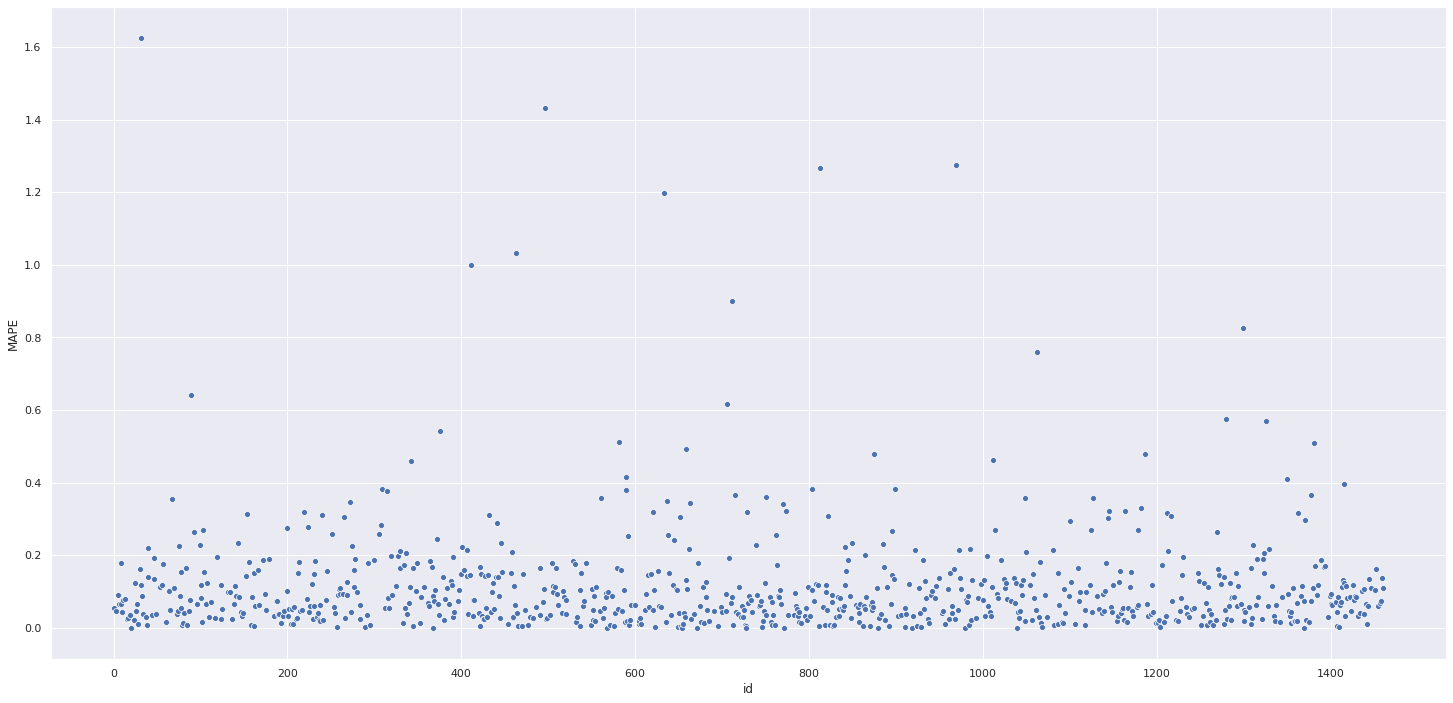

In [215]:
sns.scatterplot(x='id', y='MAPE', data= df9_2);

## **9.2 Performande Total**

In [216]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x)).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df9_3['Values'] =  df9_3['Values'].map('R${:,.2f}'.format)

In [217]:
df9_3.head()

,Scenario,Values
0,predictions,"R$143,577,780.22"
1,worst_scenario,"R$128,452,148.79"
2,best_scenario,"R$158,703,411.64"


## 9.3 Performance Total de Machine Learning

In [218]:
df9['error'] = df9['sale_price'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sale_price']

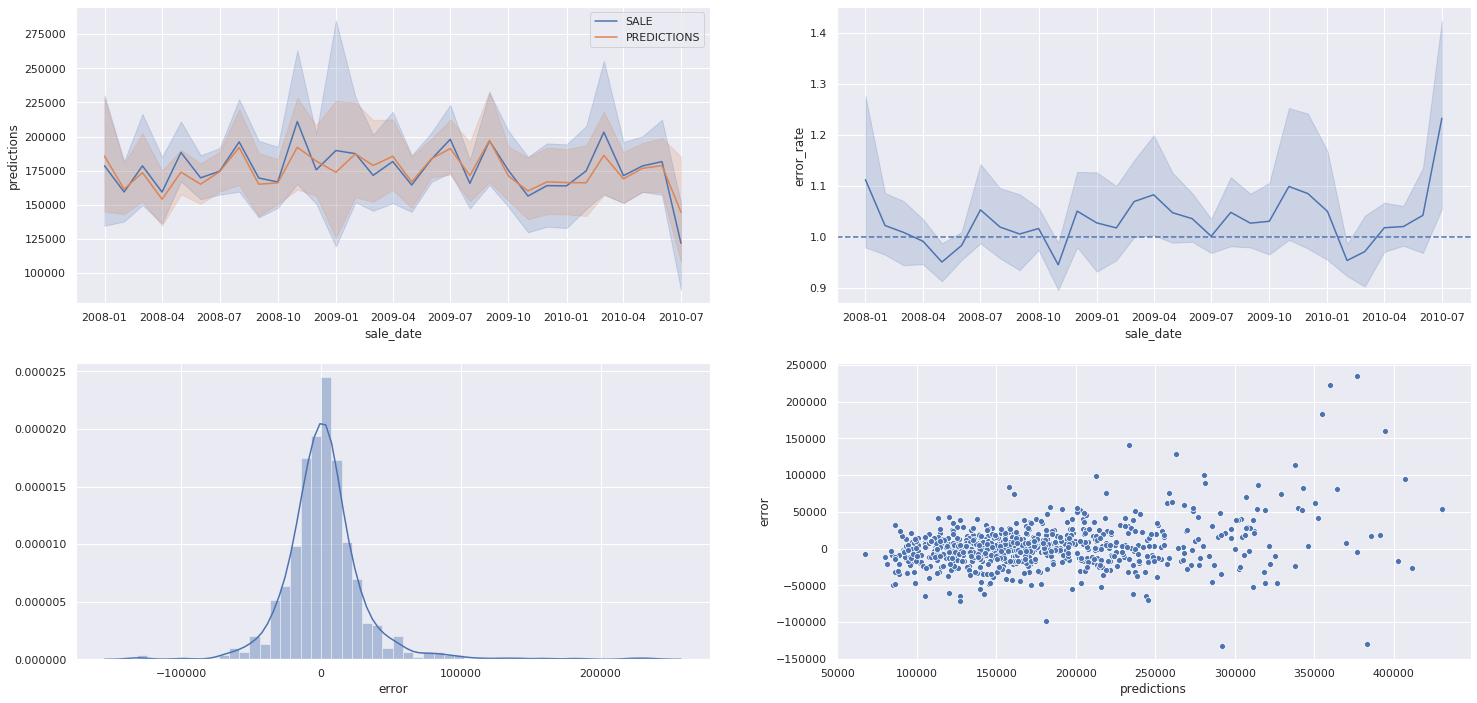

In [221]:
plt.subplot(2,2,1)
sns.lineplot(x='sale_date', y='sale_price', data=df9, label='SALE');
sns.lineplot(x='sale_date', y='predictions', data=df9, label='PREDICTIONS');

plt.subplot(2,2,2)
sns.lineplot(x='sale_date', y='error_rate', data=df9);
plt.axhline(1, linestyle='--');

plt.subplot(2,2,3)
sns.distplot(df9['error']);

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error']);

# **10.0. Deploy do Modelo para Produção**

In [364]:
pickle.dump( yhat_model_rf_tuned, open('/home/andre/repos/House-Prices/model/house_model.pkl', 'wb'))

## **10.1. Classe House**

In [304]:
import pandas as pd 
import inflection 
import math 
import datetime 
import pickle
import numpy as np


class House(object):
    def __init__(self):
        self.year_built_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/year_built_scaler.pkl', 'rb'))

        self.ms_sub_class_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/ms_sub_class_scaler.pkl', 'rb'))

        self.lot_frontage_scaler =  pickle.load(open('/home/andre/repos/House-Prices/parameter/lot_frontage_scaler.pkl', 'rb'))

        self.lot_area_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/lot_area_scaler.pkl', 'rb'))

        self.overall_cond_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/overall_cond_scaler.pkl', 'rb'))

        self.year_remod_add_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/year_remod_add_scaler.pkl', 'rb'))

        self.mas_vnr_area_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/mas_vnr_area_scaler.pkl', 'rb'))

        self.bsmt_fin_sf1_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_fin_sf1_scaler.pkl', 'rb'))

        self.bsmt_fin_sf2_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_fin_sf2_scaler.pkl', 'rb'))

        self.bsmt_unf_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_unf_sf_scaler.pkl', 'rb'))

        self.total_bsmt_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/total_bsmt_sf_scaler.pkl', 'rb'))

        self.st_flr_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/1st_flr_sf_scaler.pkl', 'rb'))

        self.nd_flr_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/2nd_flr_sf_scaler.pkl', 'rb'))

        self.low_qual_fin_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/low_qual_fin_sf_scaler.pkl', 'rb'))

        self.gr_liv_area_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/gr_liv_area_scaler.pkl', 'rb'))

        self.bsmt_full_bath_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_full_bath_scaler.pkl', 'rb'))

        self.bsmt_half_bath_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_half_bath_scaler.pkl', 'rb'))

        self.full_bath_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/full_bath_scaler.pkl', 'rb'))

        self.half_bath_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/half_bath_scaler.pkl', 'rb'))

        self.bsmt_full_bath_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_full_bath_scaler.pkl', 'rb'))

        self.bedroom_abv_gr_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bedroom_abv_gr_scaler.pkl', 'rb'))

        self.kitchen_qual_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/kitchen_qual_scaler.pkl', 'rb'))
        
        self.kitchen_abv_gr_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/kitchen_abv_gr_scaler.pkl', 'rb'))

        self.tot_rms_abv_grd_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/tot_rms_abv_grd_scaler.pkl', 'rb'))

        self.fireplaces_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/fireplaces_scaler.pkl', 'rb'))

        self.garage_yr_blt_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_yr_blt_scaler.pkl', 'rb'))

        self.garage_cars_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_cars_scaler.pkl', 'rb'))

        self.garage_area_scaler =  pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_area_scaler.pkl', 'rb'))

        self.wood_deck_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/wood_deck_sf_scaler.pkl', 'rb'))

        self.open_porch_sf_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/open_porch_sf_scaler.pkl', 'rb'))

        self.enclosed_porch_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/enclosed_porch_scaler.pkl', 'rb'))

        self.ssn_porch_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/3_ssn_porch_scaler.pkl', 'rb'))

        self.screen_porch_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/screen_porch_scaler.pkl', 'rb'))

        self.pool_area_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/pool_area_scaler.pkl', 'rb'))

        self.misc_val_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/misc_val_scaler.pkl', 'rb'))
        
        self.ms_zoning_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/ms_zoning_scaler.pkl', 'rb'))

        self.street_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/street_scaler.pkl', 'rb'))

        self.lot_shape_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/lot_shape_scaler.pkl', 'rb'))

        self.land_contour_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/land_contour_scaler.pkl', 'rb'))

        self.utilities_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/utilities_scaler.pkl', 'rb'))

        self.lot_config_scaler =  pickle.load(open('/home/andre/repos/House-Prices/parameter/lot_config_scaler.pkl', 'rb'))

        self.land_slope_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/land_slope_scaler.pkl', 'rb'))

        self.neighborhood_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/neighborhood_scaler.pkl', 'rb'))

        self.condition1_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/condition1_scaler.pkl', 'rb'))

        self.condition2_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/condition2_scaler.pkl', 'rb'))

        self.bldg_type_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bldg_type_scaler.pkl', 'rb'))

        self.house_style_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/house_style_scaler.pkl', 'rb'))

        self.overall_qual_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/overall_qual_scaler.pkl', 'rb'))

        self.roof_style_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/roof_style_scaler.pkl', 'rb'))

        self.roof_matl_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/roof_matl_scaler.pkl', 'rb'))

        self.exterior1st_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/exterior1st_scaler.pkl', 'rb'))

        self.exterior2nd_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/exterior2nd_scaler.pkl', 'rb'))

        #self.mas_vnr_type_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/mas_vnr_type_scaler.pkl', 'rb'))

        self.exter_qual_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/exter_qual_scaler.pkl', 'rb'))

        self.exter_cond_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/exter_cond_scaler.pkl', 'rb'))

        self.foundation_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/foundation_scaler.pkl', 'rb'))

        self.bsmt_qual_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_qual_scaler.pkl', 'rb'))

        self.bsmt_cond_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_cond_scaler.pkl', 'rb'))

        self.bsmt_exposure_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_exposure_scaler.pkl', 'rb'))

        self.bsmt_fin_type1_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_fin_type1_scaler.pkl', 'rb'))

        self.bsmt_fin_type2_scaler =  pickle.load(open('/home/andre/repos/House-Prices/parameter/bsmt_fin_type2_scaler.pkl', 'rb'))

        self.heating_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/heating_scaler.pkl', 'rb'))

        self.heating_qc_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/heating_qc_scaler.pkl', 'rb'))

        self.central_air_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/central_air_scaler.pkl', 'rb'))

        self.electrical_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/electrical_scaler.pkl', 'rb'))

        self.functional_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/functional_scaler.pkl', 'rb'))

        self.garage_type_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_type_scaler.pkl', 'rb'))

        self.garage_finish_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_finish_scaler.pkl', 'rb'))

        self.garage_qual_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_qual_scaler.pkl', 'rb'))

        self.garage_cond_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/garage_cond_scaler.pkl', 'rb'))

        self.paved_drive_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/paved_drive_scaler.pkl', 'rb'))

        self.sale_type_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/sale_type_scaler.pkl', 'rb'))

        self.sale_condition_scaler = pickle.load(open('/home/andre/repos/House-Prices/parameter/sale_condition_scaler.pkl', 'rb'))

       

    
    def data_cleaning(self, df1):

        columns_old = ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street','Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType','HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF','LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual','TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual','GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC','Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition']


        #alterando o formato dos nomes das colunas 
        snakecase = lambda x: inflection.underscore(x)
        cols_new = list(map(snakecase,columns_old))
        df1.columns = cols_new


        # dropando as colunas que não tem como arrumar 
        df1 = df1.drop(['alley', 'pool_qc', 'fence', 'misc_feature', 'fireplace_qu'], axis=1)

        #lot_frontage 
        df1['lot_frontage'].fillna(60, inplace=True)

        #bsmt_qual            
        df1['bsmt_qual'].fillna('TA', inplace=True)

        #bsmt_cond  
        df1['bsmt_cond'].fillna('TA', inplace=True)

        #bsmt_exposure        
        df1['bsmt_exposure'].fillna('NO', inplace=True)

        #bsmt_fin_type1 
        df1['bsmt_fin_type1'].fillna('Unf', inplace=True)

        #bsmt_fin_type2
        df1['bsmt_fin_type2'].fillna('Unf', inplace=True)

        #mas_vnr_type   
        #df1['mas_vnr_type'].fillna('None', inplace=True)
        df1.drop('mas_vnr_type', axis=1)

        #mas_vnr_area 
        df1['mas_vnr_area'].fillna(0, inplace=True)

        #electrical
        df1['electrical'].fillna('SBrkr', inplace=True)

        #garage_type   
        df1['garage_type'].fillna('Attchd', inplace=True)

        #garage_yr_blt(CONVERTER PARA YEAR)   
        df1['garage_yr_blt'].fillna(2005, inplace=True)

        #garage_finish
        df1['garage_finish'].fillna('Unf', inplace=True)

        #garage_qual  
        df1['garage_qual'].fillna('TA', inplace=True)

        #garage_cond
        df1['garage_cond'].fillna('TA', inplace=True)

        # Arrumando os formatos das colunas, conforme o necessário 
        #alterando o tipo da colunas abaixo de float para int

        # Os valores de anos serão, por padrão, INT

        #garage_yr_blt
        df1['garage_yr_blt'] = df1['garage_yr_blt'].astype(int)

        #mas_vnr_area
        df1['mas_vnr_area'] = df1['mas_vnr_area'].astype(int)

        #lot_frontage
        df1['lot_frontage'] = df1['lot_frontage'].astype(int)


        #alterando as colunas com valores numéricos para o tipo INT(JÁ FEITO)

        # alterando o tipo da coluna de INT para STR
        df1['overall_qual'] = df1['overall_qual'].astype(str)
        

        
        return df1



    def feature_engineer(self, df2):
        # Fazendo a criação de novas variáveis que sejam úteis para o modelo 

        df2['sale_date'] = df2['mo_sold'].astype(str) + df2['yr_sold'].astype(str)
        df2['sale_date'] = pd.to_datetime(df2['sale_date'], format='%m%Y')
        df2 = df2.drop_duplicates()

        # Selecionando colunas para excluir
        df2 = df2.drop(['mo_sold', 'yr_sold'], axis=1)

        return df2
    
    
    
    def data_preparation(self,df1, df5):


        df5['year_built'] = self.year_built_scaler.fit_transform(df5[['year_built']].values)

        df5['ms_sub_class'] = self.ms_sub_class_scaler.fit_transform(df5[['ms_sub_class']].values)

        df5['lot_frontage'] = self.lot_frontage_scaler.fit_transform(df5[['lot_frontage']].values)

        df5['lot_area'] = self.lot_area_scaler.fit_transform(df5[['lot_area']].values)

        df5['overall_cond'] = self.overall_cond_scaler.fit_transform(df5[['overall_cond']].values)

        df5['year_remod_add'] = self.year_remod_add_scaler.fit_transform(df5[['year_remod_add']].values)

        df5['mas_vnr_area'] = self.mas_vnr_area_scaler.fit_transform(df5[['mas_vnr_area']].values)

        df5['bsmt_fin_sf1'] = self.bsmt_fin_sf1_scaler.fit_transform(df5[['bsmt_fin_sf1']].values)

        df5['bsmt_fin_sf2'] = self.bsmt_fin_sf2_scaler.fit_transform(df5[['bsmt_fin_sf2']].values)

        df5['bsmt_unf_sf'] = self.bsmt_unf_sf_scaler.fit_transform(df5[['bsmt_unf_sf']].values)

        df5['total_bsmt_sf'] = self.total_bsmt_sf_scaler.fit_transform(df5[['total_bsmt_sf']].values)

        df5['1st_flr_sf'] = self.st_flr_sf_scaler.fit_transform(df5[['1st_flr_sf']].values)

        df5['2nd_flr_sf'] = self.nd_flr_sf_scaler.fit_transform(df5[['2nd_flr_sf']].values)

        df5['low_qual_fin_sf'] = self.low_qual_fin_sf_scaler.fit_transform(df5[['low_qual_fin_sf']].values)

        df5['gr_liv_area'] = self.gr_liv_area_scaler.fit_transform(df5[['gr_liv_area']].values)

        df5['bsmt_full_bath'] = self.bsmt_full_bath_scaler.fit_transform(df5[['bsmt_full_bath']].values)

        df5['bsmt_half_bath'] = self.bsmt_half_bath_scaler.fit_transform(df5[['bsmt_half_bath']].values)

        df5['full_bath'] = self.full_bath_scaler.fit_transform(df5[['full_bath']].values)

        df5['half_bath'] = self.half_bath_scaler.fit_transform(df5[['half_bath']].values)

        df5['bedroom_abv_gr'] = self.bedroom_abv_gr_scaler.fit_transform(df5[['bedroom_abv_gr']].values)

        df5['kitchen_abv_gr'] = self.kitchen_abv_gr_scaler.fit_transform(df5[['kitchen_abv_gr']].values)

        df5['tot_rms_abv_grd'] = self.tot_rms_abv_grd_scaler.fit_transform(df5[['tot_rms_abv_grd']].values)

        df5['fireplaces'] = self.fireplaces_scaler.fit_transform(df5[['fireplaces']].values)

        df5['garage_yr_blt'] = self.garage_yr_blt_scaler.fit_transform(df5[['garage_yr_blt']].values)

        df5['garage_cars'] = self.garage_cars_scaler.fit_transform(df5[['garage_cars']].values)

        df5['garage_area'] = self.garage_area_scaler.fit_transform(df5[['garage_area']].values)

        df5['wood_deck_sf'] = self.wood_deck_sf_scaler.fit_transform(df5[['wood_deck_sf']].values)

        df5['open_porch_sf'] = self.open_porch_sf_scaler.fit_transform(df5[['open_porch_sf']].values)

        df5['enclosed_porch'] = self.enclosed_porch_scaler.fit_transform(df5[['enclosed_porch']].values)

        df5['3_ssn_porch'] = self.ssn_porch_scaler.fit_transform(df5[['3_ssn_porch']].values)

        df5['screen_porch'] = self.screen_porch_scaler.fit_transform(df5[['screen_porch']].values)

        df5['pool_area'] = self.pool_area_scaler.fit_transform(df5[['pool_area']].values)

        df5['misc_val'] = self.misc_val_scaler.fit_transform(df5[['misc_val']].values)


        #Label Encoder

        df5['ms_zoning'] = self.ms_zoning_scaler.fit_transform(df5['ms_zoning'])

        df5['street'] = self.street_scaler.fit_transform(df5['street'])

        df5['lot_shape'] = self.lot_shape_scaler.fit_transform(df5['lot_shape'])

        df5['land_contour'] = self.land_contour_scaler.fit_transform(df5['land_contour'])

        df5['utilities'] = self.utilities_scaler.fit_transform(df5['utilities'])

        df5['lot_config'] = self.lot_config_scaler.fit_transform(df5['lot_config'])

        df5['land_slope'] = self.land_slope_scaler.fit_transform(df5['land_slope'])

        df5['neighborhood'] = self.neighborhood_scaler.fit_transform(df5['neighborhood'])

        df5['condition1'] = self.condition1_scaler.fit_transform(df5['condition1'])

        df5['condition2'] = self.condition2_scaler.fit_transform(df5['condition2'])

        df5['bldg_type'] = self.bldg_type_scaler.fit_transform(df5['bldg_type'])

        df5['house_style'] = self.house_style_scaler.fit_transform(df5['house_style'])

        df5['overall_qual'] = self.overall_qual_scaler.fit_transform(df5['overall_qual'])

        df5['roof_style'] = self.roof_style_scaler.fit_transform(df5['roof_style'])

        df5['roof_matl'] = self.roof_matl_scaler.fit_transform(df5['roof_matl'])

        df5['exterior1st'] = self.exterior1st_scaler.fit_transform(df5['exterior1st'])

        df5['exterior2nd'] = self.exterior2nd_scaler.fit_transform(df5['exterior2nd'])

        #df5['mas_vnr_type'] = self.mas_vnr_type_scaler.fit_transform(df5['mas_vnr_type'])

        df5['exter_qual'] = self.exter_qual_scaler.fit_transform(df5['exter_qual'])

        df5['exter_cond'] = self.exter_cond_scaler.fit_transform(df5['exter_cond'])

        df5['foundation'] = self.foundation_scaler.fit_transform(df5['foundation'])

        df5['bsmt_qual'] = self.bsmt_qual_scaler.fit_transform(df5['bsmt_qual'])

        df5['bsmt_cond'] = self.bsmt_cond_scaler.fit_transform(df5['bsmt_cond'])

        df5['bsmt_exposure'] = self.bsmt_exposure_scaler.fit_transform(df5['bsmt_exposure'])

        df5['bsmt_fin_type1'] = self.bsmt_fin_type1_scaler.fit_transform(df5['bsmt_fin_type1'])

        df5['bsmt_fin_type2'] = self.bsmt_fin_type2_scaler.fit_transform(df5['bsmt_fin_type2'])

        df5['heating'] = self.heating_scaler.fit_transform(df5['heating'])

        df5['heating_qc'] = self.heating_qc_scaler.fit_transform(df5['heating_qc'])

        df5['central_air'] = self.central_air_scaler.fit_transform(df5['central_air'])

        df5['electrical'] = self.electrical_scaler.fit_transform(df5['electrical'])

        df5['kitchen_qual'] = self.kitchen_qual_scaler.fit_transform(df5['kitchen_qual'])

        df5['functional'] = self.functional_scaler.fit_transform(df5['functional'])

        df5['garage_type'] = self.garage_type_scaler.fit_transform(df5['garage_type'])

        df5['garage_finish'] = self.garage_finish_scaler.fit_transform(df5['garage_finish'])

        df5['garage_qual'] = self.garage_qual_scaler.fit_transform(df5['garage_qual'])

        df5['garage_cond'] = self.garage_cond_scaler.fit_transform(df5['garage_cond'])

        df5['paved_drive'] = self.paved_drive_scaler.fit_transform(df5['paved_drive'])

        df5['sale_type'] = self.sale_type_scaler.fit_transform(df5['sale_type'])

        df5['sale_condition'] = self.sale_condition_scaler.fit_transform(df5['sale_condition'])


        #VARIÁVEIS CÍCLICAS 

        df5['sale_date_sin'] = df1['mo_sold'].apply(lambda x: np.sin(x *(2. * np.pi /30)))
        df5['sale_date_cos'] = df1['mo_sold'].apply(lambda x: np.cos(x *(2. * np.pi /30)))
        
        cols_selected = ['ms_zoning','lot_area','neighborhood','overall_qual','overall_cond','year_built','year_remod_add','exter_qual','bsmt_qual','bsmt_fin_sf1',
                        'bsmt_unf_sf','total_bsmt_sf','1st_flr_sf','2nd_flr_sf','gr_liv_area','full_bath','garage_finish','garage_cars','garage_area']
        
        return df5[cols_selected]
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)
        
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')

## **10.2. API Handler**

In [380]:
import pandas as pd 
from flask import Flask, request, Response
from house.House import House
import pickle

#  carregando modelo 
model = pickle.load(open('/home/andre/repos/House-Prices/model/house_model.pkl', 'rb'))

app = Flask(__name__)

@app.route('/house/predict', methods=['POST'])

def house_predict():
    test_json = request.get_json()
    
    
    if test_json: #tem dados
        if isinstance(test_json, dict): # exemplo único 
            test_raw = pd.Dataframe(test_json, index=[0])
        
        else:
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        # instanciando classe House 
        pipeline = House()
        
        # limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # atributo dos dados 
        df2 = pipeline.feature_engineer(df1)
        
        # preparação dos dados
        df3 = pipeline.data_preparation(df1, df2)
        
        # predição dos dados
        df_response = pipeline.get_prediction(model, test_raw, df3)
                               
        
        return df_response
    
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
    print(test_json)
    
if __name__ == '__main__':
    app.run('127.0.0.1')

ModuleNotFoundError: No module named 'house'

## **10.3. Testador de API**

In [457]:
import requests

In [458]:
# carregando o dataset de teste
df10 = pd.read_csv('/home/andre/repos/House-Prices/data/test.csv')

In [459]:
# escolhendo uma loja específica 
df10 = df10[df10['Id'].isin([1550, 1750, 1850])] 

In [460]:
# convertendo o Datafram em Json
data = json.dumps(df10.to_dict(orient='records'))

In [461]:
# chamando a API 
#url = 'http://127.0.0.1:5000/house/predict'
url = 'https://model-house-price-prediction.herokuapp.com/house/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data= data, headers= header)
print('Status code: {}'.format(r.status_code))

Status code: 200


In [462]:
# transformando os dados JSON em um DataFrame novamente 
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [463]:
for i in range(len(d1)):
    print("A casa número {} será vendida por R$ {:,.2f}".format(d1['id'][i],d1['prediction'][i]))

A casa número 1550 será vendida por R$ 285,845.79
A casa número 1750 será vendida por R$ 234,043.25
A casa número 1850 será vendida por R$ 138,573.39
